In [1288]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:.5f}'.format

In [1289]:
import warnings
warnings.filterwarnings('always')

In [1290]:
train_demo = pd.read_csv("traindemographics.csv", parse_dates=['birthdate'])
trainperf = pd.read_csv("trainperf.csv", parse_dates=['approveddate','creationdate'])
train_loan = pd.read_csv("trainprevloans.csv", parse_dates=['approveddate','creationdate','loanamount','closeddate','firstduedate','firstrepaiddate'])

test_demo = pd.read_csv("testdemographics.csv", parse_dates=['birthdate'])
testperf = pd.read_csv("testperf.csv", parse_dates=['approveddate','creationdate'])
test_loan = pd.read_csv("testprevloans.csv", parse_dates=['approveddate','creationdate','loanamount','closeddate','firstduedate','firstrepaiddate'])

In [1291]:
test_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858f305c8dd672015c93b1db645db4,1976-08-28,Savings,5.29663,7.59396,Heritage Bank,NaN,Permanent,NaN
1,8a858f085a477386015a47fb049e49ca,1978-06-23,Savings,3.29451,6.59660,UBA,NaN,Permanent,NaN
2,8a858e6f5cd5e874015cd6f5634c39ad,1984-04-04,Savings,8.50191,7.72936,First Bank,NaN,Permanent,NaN
3,8a858e9d5bfd7037015bfdab79f61305,1983-05-28,Savings,3.31890,6.68159,UBA,NaN,Permanent,NaN
4,8a858fde56eb02280156eb6dafc128ac,1982-03-29,Savings,6.35462,4.94903,First Bank,NaN,Self-Employed,NaN


In [1292]:
test_loan.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301621635,3,2016-05-17 10:37:00,2016-05-17 09:36:55,10000.0000,13000.00000,30,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301810201,5,2017-02-04 21:28:59,2017-02-04 20:28:52,30000.0000,36800.00000,60,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
2,8a858959537a097401537a4e316e25f7,301831255,6,2017-03-04 10:28:22,2017-03-04 09:28:16,30000.0000,34400.00000,30,2017-04-02 00:44:24,NaN,2017-04-03,2017-04-01 21:29:46
3,8a8589c253ace09b0153af6ba58f1f31,301627292,3,2016-06-02 14:27:14,2016-06-02 13:27:08,10000.0000,13000.00000,30,2016-07-04 11:34:04,NaN,2016-07-04,2016-07-04 11:19:01
4,8a8589c253ace09b0153af6ba58f1f31,301621095,2,2016-05-16 09:13:12,2016-05-16 08:13:04,10000.0000,11500.00000,15,2016-06-02 00:02:58,NaN,2016-05-31,2016-06-01 15:22:34


In [1293]:
testperf.tail()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
1445,8a858fb45bb59c21015bb88a191f58f2,301991141,3,47:02.0,46:53.0,10000,11500.00000,15,NaN
1446,8a858fcb5b00cc54015b0253ced26a5f,301963018,3,00:45.0,04:05.0,10000,13000.00000,30,NaN
1447,8a858fde56eb02280156f59b976d46c0,301994653,9,09:40.0,09:33.0,40000,48000.00000,60,NaN
1448,8a858e10570f2d65015717fcfec44996,301961483,14,47:54.0,46:49.0,60000,68100.00000,90,NaN
1449,8a858f605b911d60015b91b99d55400d,301973097,6,12:09.0,12:03.0,20000,22250.00000,15,8a858ff259d1429e0159d2d0194c4b8e


In [1294]:
testperf['approveddate'] = pd.to_datetime(testperf['approveddate'], errors='coerce') # fill the original input for bad data
testperf['creationdate'] = pd.to_datetime(testperf['creationdate'], errors='coerce') # fill the original input for bad data

In [1295]:
testperf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby
0,8a858899538ddb8e015390510b321f08,301998974,4,NaT,NaT,10000,12250.00000,30,NaN
1,8a858959537a097401537a4e316e25f7,301963615,10,NaT,NaT,40000,44000.00000,30,NaN
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,2022-04-17 15:11:00,2022-04-17 15:04:00,20000,24500.00000,30,NaN
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,2022-04-17 00:54:00,2022-04-17 00:49:00,30000,34500.00000,30,NaN
4,8a858e225a28c713015a30db5c48383d,301959177,4,2022-04-17 04:33:00,2022-04-17 04:27:00,20000,24500.00000,30,NaN


In [1296]:
train_demo.head()

,customerid,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a858e135cb22031015cbafc76964ebd,1973-10-10,Savings,3.31922,6.52860,GT Bank,NaN,NaN,NaN
1,8a858e275c7ea5ec015c82482d7c3996,1986-01-21,Savings,3.32560,7.11940,Sterling Bank,NaN,Permanent,NaN
2,8a858e5b5bd99460015bdc95cd485634,1987-04-01,Savings,5.74610,5.56317,Fidelity Bank,NaN,NaN,NaN
3,8a858efd5ca70688015cabd1f1e94b55,1991-07-19,Savings,3.36285,6.64249,GT Bank,NaN,Permanent,NaN
4,8a858e785acd3412015acd48f4920d04,1982-11-22,Savings,8.45533,11.97141,GT Bank,NaN,Permanent,NaN


In [1297]:
trainperf.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.00000,17250.00000,30,NaN,Good
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.00000,22250.00000,15,NaN,Good
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.00000,11500.00000,15,NaN,Good
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.00000,44000.00000,30,NaN,Good


In [1298]:
train_loan.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,closeddate,referredby,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301682320,2,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0000,13000.00000,30,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a2a81a74ce8c05d014cfb32a0da1049,301883808,9,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0000,13000.00000,30,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,8a2a81a74ce8c05d014cfb32a0da1049,301831714,8,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0000,23800.00000,30,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47
3,8a8588f35438fe12015444567666018e,301861541,5,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0000,11500.00000,15,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43
4,8a85890754145ace015429211b513e16,301941754,2,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0000,11500.00000,15,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35


In [1299]:
train_demo.shape, trainperf.shape, train_loan.shape

((4346, 9), (4368, 10), (18183, 12))

In [1300]:
train_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18183 entries, 0 to 18182
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customerid       18183 non-null  object        
 1   systemloanid     18183 non-null  int64         
 2   loannumber       18183 non-null  int64         
 3   approveddate     18183 non-null  datetime64[ns]
 4   creationdate     18183 non-null  datetime64[ns]
 5   loanamount       18183 non-null  object        
 6   totaldue         18183 non-null  float64       
 7   termdays         18183 non-null  int64         
 8   closeddate       18183 non-null  datetime64[ns]
 9   referredby       1026 non-null   object        
 10  firstduedate     18183 non-null  datetime64[ns]
 11  firstrepaiddate  18183 non-null  datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(3), object(3)
memory usage: 1.7+ MB


In [1301]:
train_loan.isna().sum()

customerid             0
systemloanid           0
loannumber             0
approveddate           0
creationdate           0
loanamount             0
totaldue               0
termdays               0
closeddate             0
referredby         17157
firstduedate           0
firstrepaiddate        0
dtype: int64

In [1302]:
train1 = pd.merge(trainperf,train_demo, on=['customerid'], how='left')
test1 = pd.merge(testperf,test_demo, on=['customerid'], how='left')

In [1303]:
train1.head()

,customerid,systemloanid,loannumber,approveddate,creationdate,loanamount,totaldue,termdays,referredby,good_bad_flag,birthdate,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,bank_branch_clients,employment_status_clients,level_of_education_clients
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,1972-01-15,Other,3.43201,6.43306,Diamond Bank,NaN,Permanent,Post-Graduate
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.00000,17250.00000,30,NaN,Good,1985-08-23,Savings,3.88530,7.32070,GT Bank,"DUGBE,IBADAN",Permanent,Graduate
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.00000,22250.00000,15,NaN,Good,1984-09-18,Other,11.13935,10.29204,EcoBank,NaN,Permanent,NaN
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.00000,11500.00000,15,NaN,Good,1977-10-10,Savings,3.98577,7.49171,First Bank,NaN,Permanent,NaN
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.00000,44000.00000,30,NaN,Good,1986-09-07,Other,7.45791,9.07657,GT Bank,NaN,Permanent,Primary


In [1304]:
train = pd.merge(train1,train_loan, on=['customerid'], how='left')
test = pd.merge(test1,test_loan, on=['customerid'], how='left')

In [1305]:
test['customerid'] = test['customerid'].drop_duplicates(keep='first', inplace=False)

In [1306]:
test

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301998974,4,NaT,NaT,10000,12250.00000,30,NaN,NaT,...,3.00000,2016-05-17 10:37:00,2016-05-17 09:36:55,10000.0000,13000.00000,30.00000,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,NaN,301998974,4,NaT,NaT,10000,12250.00000,30,NaN,NaT,...,1.00000,2016-03-21 19:47:23,2016-03-21 18:47:15,6000.0000,6900.00000,15.00000,2016-04-05 00:02:59,NaN,2016-04-05,2016-04-04 12:30:36
2,NaN,301998974,4,NaT,NaT,10000,12250.00000,30,NaN,NaT,...,2.00000,2016-04-05 21:20:10,2016-04-05 20:20:02,10000.0000,13000.00000,30.00000,2016-05-17 00:04:26,NaN,2016-05-05,2016-05-16 18:49:23
3,8a858959537a097401537a4e316e25f7,301963615,10,NaT,NaT,40000,44000.00000,30,NaN,NaT,...,5.00000,2017-02-04 21:28:59,2017-02-04 20:28:52,30000.0000,36800.00000,60.00000,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
4,NaN,301963615,10,NaT,NaT,40000,44000.00000,30,NaN,NaT,...,6.00000,2017-03-04 10:28:22,2017-03-04 09:28:16,30000.0000,34400.00000,30.00000,2017-04-02 00:44:24,NaN,2017-04-03,2017-04-01 21:29:46
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5910,8a858f605b911d60015b91b99d55400d,301973097,6,2022-04-17 12:09:00,2022-04-17 12:03:00,20000,22250.00000,15,8a858ff259d1429e0159d2d0194c4b8e,NaT,...,1.00000,2017-04-22 08:43:29,2017-04-22 07:43:18,10000.0000,11500.00000,15.00000,2017-05-07 16:22:50,8a858ff259d1429e0159d2d0194c4b8e,2017-05-08,2017-05-07 16:07:40
5911,NaN,301973097,6,2022-04-17 12:09:00,2022-04-17 12:03:00,20000,22250.00000,15,8a858ff259d1429e0159d2d0194c4b8e,NaT,...,4.00000,2017-06-08 11:04:27,2017-06-08 10:04:20,10000.0000,11125.00000,15.00000,2017-06-23 22:55:33,8a858ff259d1429e0159d2d0194c4b8e,2017-06-23,2017-06-23 22:45:23
5912,NaN,301973097,6,2022-04-17 12:09:00,2022-04-17 12:03:00,20000,22250.00000,15,8a858ff259d1429e0159d2d0194c4b8e,NaT,...,2.00000,2017-05-08 12:18:40,2017-05-08 11:18:33,10000.0000,11500.00000,15.00000,2017-05-23 19:05:10,8a858ff259d1429e0159d2d0194c4b8e,2017-05-23,2017-05-23 18:50:02
5913,NaN,301973097,6,2022-04-17 12:09:00,2022-04-17 12:03:00,20000,22250.00000,15,8a858ff259d1429e0159d2d0194c4b8e,NaT,...,3.00000,2017-05-24 09:29:21,2017-05-24 08:29:13,10000.0000,11500.00000,15.00000,2017-06-08 01:11:04,8a858ff259d1429e0159d2d0194c4b8e,2017-06-08,2017-06-08 00:49:35


In [1307]:
test = test.dropna(subset=['customerid'])
test.reset_index(drop=True, inplace=True)

In [1308]:
test

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301998974,4,NaT,NaT,10000,12250.00000,30,NaN,NaT,...,3.00000,2016-05-17 10:37:00,2016-05-17 09:36:55,10000.0000,13000.00000,30.00000,2016-06-17 00:04:15,NaN,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301963615,10,NaT,NaT,40000,44000.00000,30,NaN,NaT,...,5.00000,2017-02-04 21:28:59,2017-02-04 20:28:52,30000.0000,36800.00000,60.00000,2017-03-02 16:22:58,NaN,2017-03-06,2017-03-02 16:07:47
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,2022-04-17 15:11:00,2022-04-17 15:04:00,20000,24500.00000,30,NaN,1981-09-05,...,3.00000,2016-06-02 14:27:14,2016-06-02 13:27:08,10000.0000,13000.00000,30.00000,2016-07-04 11:34:04,NaN,2016-07-04,2016-07-04 11:19:01
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,2022-04-17 00:54:00,2022-04-17 00:49:00,30000,34500.00000,30,NaN,NaT,...,6.00000,2017-05-30 16:34:15,2017-05-30 15:34:09,20000.0000,22250.00000,15.00000,2017-06-13 20:45:14,NaN,2017-06-14,2017-06-13 20:35:04
4,8a858e225a28c713015a30db5c48383d,301959177,4,2022-04-17 04:33:00,2022-04-17 04:27:00,20000,24500.00000,30,NaN,1975-08-25,...,3.00000,2017-06-05 07:42:18,2017-06-05 06:42:11,10000.0000,13000.00000,30.00000,2017-07-01 16:14:01,NaN,2017-07-05,2017-07-01 16:03:51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1445,8a858fb45bb59c21015bb88a191f58f2,301991141,3,NaT,NaT,10000,11500.00000,15,NaN,NaT,...,2.00000,2017-05-24 20:55:28,2017-05-24 19:55:21,10000.0000,11500.00000,15.00000,2017-06-06 21:17:09,NaN,2017-06-09,2017-06-06 21:07:00
1446,8a858fcb5b00cc54015b0253ced26a5f,301963018,3,2022-04-17 00:45:00,2022-04-17 04:05:00,10000,13000.00000,30,NaN,NaT,...,2.00000,2017-06-17 10:08:48,2017-06-17 09:08:42,10000.0000,11500.00000,15.00000,2017-07-03 05:41:35,NaN,2017-07-03,2017-07-03 05:09:52
1447,8a858fde56eb02280156f59b976d46c0,301994653,9,2022-04-17 09:40:00,2022-04-17 09:33:00,40000,48000.00000,60,NaN,NaT,...,6.00000,2017-01-30 12:25:29,2017-01-30 11:25:18,25000.0000,29000.00000,30.00000,2017-02-28 12:44:03,NaN,2017-03-01,2017-02-28 12:28:53
1448,8a858e10570f2d65015717fcfec44996,301961483,14,NaT,NaT,60000,68100.00000,90,NaN,NaT,...,5.00000,2016-11-18 10:59:01,2016-11-18 09:58:50,20000.0000,23800.00000,30.00000,2016-11-21 12:58:25,NaN,2016-12-19,2016-11-21 12:43:15


In [1309]:
train['customerid'] = train['customerid'].drop_duplicates(keep='first', inplace=False)

In [1310]:
train

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,good_bad_flag,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,...,2.00000,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0000,13000.00000,30.00000,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,NaN,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,...,9.00000,2017-04-28 18:39:07,2017-04-28 17:38:53,10000.0000,13000.00000,30.00000,2017-05-28 14:44:49,NaN,2017-05-30,2017-05-26 00:00:00
2,NaN,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,...,8.00000,2017-03-05 10:56:25,2017-03-05 09:56:19,20000.0000,23800.00000,30.00000,2017-04-26 22:18:56,NaN,2017-04-04,2017-04-26 22:03:47
3,NaN,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,...,10.00000,2017-06-01 13:34:30,2017-06-01 12:34:21,20000.0000,24500.00000,30.00000,2017-06-25 15:24:06,NaN,2017-07-03,2017-06-25 15:13:56
4,NaN,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,...,11.00000,2017-06-28 10:58:34,2017-06-28 09:58:25,20000.0000,24500.00000,30.00000,2017-07-25 08:14:36,NaN,2017-07-31,2017-07-25 08:04:27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18207,NaN,301967124,8,2017-07-06 21:01:06,2017-07-06 20:01:01,30000.00000,34500.00000,30,NaN,Bad,...,1.00000,2016-11-15 20:35:26,2016-11-15 19:35:10,10000.0000,13000.00000,30.00000,2016-12-06 13:18:11,NaN,2016-12-15,2016-12-06 13:03:00
18208,NaN,301967124,8,2017-07-06 21:01:06,2017-07-06 20:01:01,30000.00000,34500.00000,30,NaN,Bad,...,4.00000,2017-02-12 23:18:28,2017-02-12 22:18:22,20000.0000,23800.00000,30.00000,2017-03-11 00:44:47,NaN,2017-03-14,2017-03-11 00:29:36
18209,NaN,301967124,8,2017-07-06 21:01:06,2017-07-06 20:01:01,30000.00000,34500.00000,30,NaN,Bad,...,5.00000,2017-04-12 18:54:51,2017-04-12 17:54:39,20000.0000,23800.00000,30.00000,2017-05-10 09:13:03,NaN,2017-05-12,2017-05-10 08:57:53
18210,NaN,301967124,8,2017-07-06 21:01:06,2017-07-06 20:01:01,30000.00000,34500.00000,30,NaN,Bad,...,2.00000,2016-12-12 23:54:06,2016-12-12 22:53:56,10000.0000,13000.00000,30.00000,2017-01-11 00:02:13,NaN,2017-01-11,2017-01-10 23:47:04


In [1311]:
train = train.dropna(subset=['customerid'])
train.reset_index(drop=True, inplace=True)

In [1312]:
train

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,good_bad_flag,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,NaN,Good,...,2.00000,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.0000,13000.00000,30.00000,2016-09-01 16:06:48,NaN,2016-09-14,2016-09-01 15:51:43
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.00000,17250.00000,30,NaN,Good,...,NaN,NaT,NaT,NaN,NaN,NaN,NaT,NaN,NaT,NaT
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.00000,22250.00000,15,NaN,Good,...,5.00000,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.0000,11500.00000,15.00000,2017-04-24 01:35:52,NaN,2017-04-24,2017-04-24 00:48:43
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.00000,11500.00000,15,NaN,Good,...,2.00000,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.0000,11500.00000,15.00000,2017-07-14 21:18:43,NaN,2017-07-03,2017-07-14 21:08:35
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.00000,44000.00000,30,NaN,Good,...,5.00000,2017-03-06 13:25:17,2017-03-06 12:25:10,20000.0000,23800.00000,30.00000,2017-04-04 15:46:56,NaN,2017-04-05,2017-04-04 15:31:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,2017-07-30 09:19:42,2017-07-30 08:18:30,10000.00000,13000.00000,30,NaN,Bad,...,1.00000,2016-12-02 10:56:09,2016-12-02 09:55:57,10000.0000,13000.00000,30.00000,2017-01-07 20:36:46,NaN,2017-01-02,2017-01-07 20:21:27
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47,2017-07-27 14:35:40,10000.00000,13000.00000,30,NaN,Bad,...,1.00000,2017-06-30 17:19:59,2017-06-30 16:18:51,10000.0000,13000.00000,30.00000,2017-07-27 15:27:14,NaN,2017-07-31,2017-07-27 15:17:04
4365,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57,2017-07-25 15:24:47,10000.00000,11500.00000,15,NaN,Bad,...,1.00000,2017-04-01 22:36:26,2017-04-01 21:36:15,10000.0000,11500.00000,15.00000,2017-05-03 22:02:06,NaN,2017-04-17,2017-05-03 21:46:57
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27,2017-07-14 12:50:21,10000.00000,13000.00000,30,8a858eda5c8863ff015c9dead65807bb,Bad,...,1.00000,2017-06-13 14:39:37,2017-06-13 13:38:28,10000.0000,13000.00000,30.00000,2017-07-13 18:48:26,8a858eda5c8863ff015c9dead65807bb,2017-07-13,2017-07-13 18:38:17


In [1313]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  4368 non-null   object        
 1   systemloanid_x              4368 non-null   int64         
 2   loannumber_x                4368 non-null   int64         
 3   approveddate_x              4368 non-null   datetime64[ns]
 4   creationdate_x              4368 non-null   datetime64[ns]
 5   loanamount_x                4368 non-null   float64       
 6   totaldue_x                  4368 non-null   float64       
 7   termdays_x                  4368 non-null   int64         
 8   referredby_x                587 non-null    object        
 9   good_bad_flag               4368 non-null   object        
 10  birthdate                   3269 non-null   datetime64[ns]
 11  bank_account_type           3269 non-null   object      

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


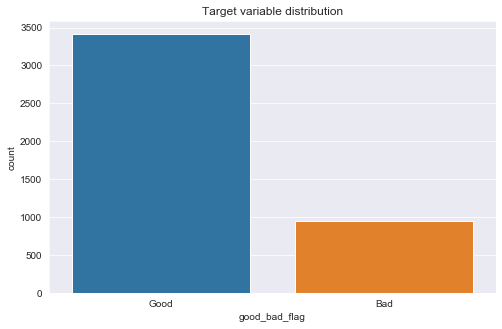

In [1314]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["good_bad_flag"])
plt.title('Target variable distribution')
plt.show()

In [1315]:
cat_cols = train.columns.difference(['customerid','systemloanid', 'birthdate','longitude_gps','latitude_gps','systemloanid_x','loannumber_x','approveddate_x','systemloanid_y','loannumber_y','approveddate_y','creationdate_x','creationdate_y','loanamount_x','loanamount_y','totaldue_x','totaldue_y','termdays_x','good_bad_flag','termdays_y','closeddate','firstduedate','firstrepaiddate']).tolist()
cat_cols

['bank_account_type',
 'bank_branch_clients',
 'bank_name_clients',
 'employment_status_clients',
 'level_of_education_clients',
 'referredby_x',
 'referredby_y']

In [1316]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  4368 non-null   object        
 1   systemloanid_x              4368 non-null   int64         
 2   loannumber_x                4368 non-null   int64         
 3   approveddate_x              4368 non-null   datetime64[ns]
 4   creationdate_x              4368 non-null   datetime64[ns]
 5   loanamount_x                4368 non-null   float64       
 6   totaldue_x                  4368 non-null   float64       
 7   termdays_x                  4368 non-null   int64         
 8   referredby_x                587 non-null    object        
 9   good_bad_flag               4368 non-null   object        
 10  birthdate                   3269 non-null   datetime64[ns]
 11  bank_account_type           3269 non-null   object      

In [1317]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1450 entries, 0 to 1449
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  1450 non-null   object        
 1   systemloanid_x              1450 non-null   int64         
 2   loannumber_x                1450 non-null   int64         
 3   approveddate_x              597 non-null    datetime64[ns]
 4   creationdate_x              591 non-null    datetime64[ns]
 5   loanamount_x                1450 non-null   int64         
 6   totaldue_x                  1450 non-null   float64       
 7   termdays_x                  1450 non-null   int64         
 8   referredby_x                184 non-null    object        
 9   birthdate                   385 non-null    datetime64[ns]
 10  bank_account_type           385 non-null    object        
 11  longitude_gps               385 non-null    float64     

In [1318]:
train['loanamount_y'] = pd.to_numeric(train['loanamount_y'])
test['loanamount_y'] = pd.to_numeric(test['loanamount_y'])                                    
train['good_bad_flag'].replace(['Good','Bad'],[1,0],inplace=True)                              

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

Se

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


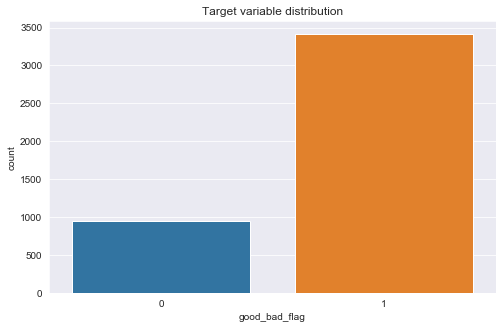

In [1319]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["good_bad_flag"])
plt.title('Target variable distribution')
plt.show()

In [1320]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  4368 non-null   object        
 1   systemloanid_x              4368 non-null   int64         
 2   loannumber_x                4368 non-null   int64         
 3   approveddate_x              4368 non-null   datetime64[ns]
 4   creationdate_x              4368 non-null   datetime64[ns]
 5   loanamount_x                4368 non-null   float64       
 6   totaldue_x                  4368 non-null   float64       
 7   termdays_x                  4368 non-null   int64         
 8   referredby_x                587 non-null    object        
 9   good_bad_flag               4368 non-null   int64         
 10  birthdate                   3269 non-null   datetime64[ns]
 11  bank_account_type           3269 non-null   object      

In [1323]:
# Fill in missing values in categorical variables with the most common
train[cat_cols] = train[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))
test[cat_cols] = test[cat_cols].apply(lambda x: x.fillna(x.value_counts().index[0]))

# Convert
for col in cat_cols:
  train[col] = train[col].astype('category')
  test[col] = test[col].astype('category')


# Confirm
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4368 entries, 0 to 4367
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   customerid                  4368 non-null   object        
 1   systemloanid_x              4368 non-null   int64         
 2   loannumber_x                4368 non-null   int64         
 3   approveddate_x              4368 non-null   datetime64[ns]
 4   creationdate_x              4368 non-null   datetime64[ns]
 5   loanamount_x                4368 non-null   float64       
 6   totaldue_x                  4368 non-null   float64       
 7   termdays_x                  4368 non-null   int64         
 8   referredby_x                4368 non-null   category      
 9   good_bad_flag               4368 non-null   int64         
 10  birthdate                   3269 non-null   datetime64[ns]
 11  bank_account_type           4368 non-null   category    

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usi

In [1324]:
train

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,good_bad_flag,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,8a858fc55b2548dd015b286e452c678c,1,...,2.00000,2016-08-15 18:22:40,2016-08-15 17:22:32,10000.00000,13000.00000,30.00000,2016-09-01 16:06:48,8a858fc55b2548dd015b286e452c678c,2016-09-14,2016-09-01 15:51:43
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.00000,17250.00000,30,8a858fc55b2548dd015b286e452c678c,1,...,NaN,NaT,NaT,NaN,NaN,NaN,NaT,8a858fc55b2548dd015b286e452c678c,NaT,NaT
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.00000,22250.00000,15,8a858fc55b2548dd015b286e452c678c,1,...,5.00000,2017-04-09 18:25:55,2017-04-09 17:25:42,10000.00000,11500.00000,15.00000,2017-04-24 01:35:52,8a858fc55b2548dd015b286e452c678c,2017-04-24,2017-04-24 00:48:43
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.00000,11500.00000,15,8a858fc55b2548dd015b286e452c678c,1,...,2.00000,2017-06-17 09:29:57,2017-06-17 08:29:50,10000.00000,11500.00000,15.00000,2017-07-14 21:18:43,8a858fc55b2548dd015b286e452c678c,2017-07-03,2017-07-14 21:08:35
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.00000,44000.00000,30,8a858fc55b2548dd015b286e452c678c,1,...,5.00000,2017-03-06 13:25:17,2017-03-06 12:25:10,20000.00000,23800.00000,30.00000,2017-04-04 15:46:56,8a858fc55b2548dd015b286e452c678c,2017-04-05,2017-04-04 15:31:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4363,8a858e6d58b0cc520158beeb14b22a5a,302003163,2,2017-07-30 09:19:42,2017-07-30 08:18:30,10000.00000,13000.00000,30,8a858fc55b2548dd015b286e452c678c,0,...,1.00000,2016-12-02 10:56:09,2016-12-02 09:55:57,10000.00000,13000.00000,30.00000,2017-01-07 20:36:46,8a858fc55b2548dd015b286e452c678c,2017-01-02,2017-01-07 20:21:27
4364,8a858ee85cf400f5015cf44ab1c42d5c,301998967,2,2017-07-27 15:35:47,2017-07-27 14:35:40,10000.00000,13000.00000,30,8a858fc55b2548dd015b286e452c678c,0,...,1.00000,2017-06-30 17:19:59,2017-06-30 16:18:51,10000.00000,13000.00000,30.00000,2017-07-27 15:27:14,8a858fc55b2548dd015b286e452c678c,2017-07-31,2017-07-27 15:17:04
4365,8a858f365b2547f3015b284597147c94,301995576,3,2017-07-25 16:25:57,2017-07-25 15:24:47,10000.00000,11500.00000,15,8a858fc55b2548dd015b286e452c678c,0,...,1.00000,2017-04-01 22:36:26,2017-04-01 21:36:15,10000.00000,11500.00000,15.00000,2017-05-03 22:02:06,8a858fc55b2548dd015b286e452c678c,2017-04-17,2017-05-03 21:46:57
4366,8a858f935ca09667015ca0ee3bc63f51,301977679,2,2017-07-14 13:50:27,2017-07-14 12:50:21,10000.00000,13000.00000,30,8a858eda5c8863ff015c9dead65807bb,0,...,1.00000,2017-06-13 14:39:37,2017-06-13 13:38:28,10000.00000,13000.00000,30.00000,2017-07-13 18:48:26,8a858eda5c8863ff015c9dead65807bb,2017-07-13,2017-07-13 18:38:17


In [1325]:
X = train.drop(columns='good_bad_flag', axis=1)
Y = train['good_bad_flag']

In [1326]:
#////////////////////////////////////////////////////////////////////////////////////////////////////////////
for i in X.columns[X.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    X[i].fillna(X[i].mean(),inplace=True)
X.iloc[4:] = X.iloc[4:].round(decimals = 2)    

In [1327]:
train = X.assign(good_bad_flag = Y)

In [1328]:
train.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,8a858fc55b2548dd015b286e452c678c,1972-01-15,...,2016-08-15 18:22:40.000000000,2016-08-15 17:22:32.000000000,10000.00000,13000.00000,30.00000,2016-09-01 16:06:48.000000000,8a858fc55b2548dd015b286e452c678c,2016-09-14 00:00:00.000000000,2016-09-01 15:51:43.000000000,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.00000,17250.00000,30,8a858fc55b2548dd015b286e452c678c,1985-08-23,...,2017-04-13 23:36:56.868777216,2017-04-13 22:33:01.322321664,13002.75292,15741.81289,25.36820,2017-05-07 11:51:18.843083264,8a858fc55b2548dd015b286e452c678c,2017-05-08 17:22:55.086028800,2017-05-07 01:11:13.818306816,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.00000,22250.00000,15,8a858fc55b2548dd015b286e452c678c,1984-09-18,...,2017-04-09 18:25:55.000000000,2017-04-09 17:25:42.000000000,10000.00000,11500.00000,15.00000,2017-04-24 01:35:52.000000000,8a858fc55b2548dd015b286e452c678c,2017-04-24 00:00:00.000000000,2017-04-24 00:48:43.000000000,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.00000,11500.00000,15,8a858fc55b2548dd015b286e452c678c,1977-10-10,...,2017-06-17 09:29:57.000000000,2017-06-17 08:29:50.000000000,10000.00000,11500.00000,15.00000,2017-07-14 21:18:43.000000000,8a858fc55b2548dd015b286e452c678c,2017-07-03 00:00:00.000000000,2017-07-14 21:08:35.000000000,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.00000,44000.00000,30,8a858fc55b2548dd015b286e452c678c,1986-09-07,...,2017-03-06 13:25:17.000000000,2017-03-06 12:25:10.000000000,20000.00000,23800.00000,30.00000,2017-04-04 15:46:56.000000000,8a858fc55b2548dd015b286e452c678c,2017-04-05 00:00:00.000000000,2017-04-04 15:31:47.000000000,1


In [1329]:
for i in test.columns[test.isnull().any(axis=0)]:     #---Applying Only on variables with NaN values
    test[i].fillna(test[i].mean(),inplace=True)
test = test.round(decimals = 2) 

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\pandas\core\generic.py:6392: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/us

In [1330]:
test.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,loannumber_y,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate
0,8a858899538ddb8e015390510b321f08,301998974,4,2022-04-17 11:34:02.010050304,2022-04-17 11:39:37.461928960,10000,12250.00000,30,8a858f5b5bee1b11015bee3c86711191,1984-11-16 17:38:29.610389632,...,3.00000,2016-05-17 10:37:00,2016-05-17 09:36:55,10000.00000,13000.00000,30.00000,2016-06-17 00:04:15,8a858fc15b68ba6a015b6d46f82b05f9,2016-06-16,2016-06-16 15:44:08
1,8a858959537a097401537a4e316e25f7,301963615,10,2022-04-17 11:34:02.010050304,2022-04-17 11:39:37.461928960,40000,44000.00000,30,8a858f5b5bee1b11015bee3c86711191,1984-11-16 17:38:29.610389632,...,5.00000,2017-02-04 21:28:59,2017-02-04 20:28:52,30000.00000,36800.00000,60.00000,2017-03-02 16:22:58,8a858fc15b68ba6a015b6d46f82b05f9,2017-03-06,2017-03-02 16:07:47
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,2022-04-17 15:11:00.000000000,2022-04-17 15:04:00.000000000,20000,24500.00000,30,8a858f5b5bee1b11015bee3c86711191,1981-09-05 00:00:00.000000000,...,3.00000,2016-06-02 14:27:14,2016-06-02 13:27:08,10000.00000,13000.00000,30.00000,2016-07-04 11:34:04,8a858fc15b68ba6a015b6d46f82b05f9,2016-07-04,2016-07-04 11:19:01
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,2022-04-17 00:54:00.000000000,2022-04-17 00:49:00.000000000,30000,34500.00000,30,8a858f5b5bee1b11015bee3c86711191,1984-11-16 17:38:29.610389632,...,6.00000,2017-05-30 16:34:15,2017-05-30 15:34:09,20000.00000,22250.00000,15.00000,2017-06-13 20:45:14,8a858fc15b68ba6a015b6d46f82b05f9,2017-06-14,2017-06-13 20:35:04
4,8a858e225a28c713015a30db5c48383d,301959177,4,2022-04-17 04:33:00.000000000,2022-04-17 04:27:00.000000000,20000,24500.00000,30,8a858f5b5bee1b11015bee3c86711191,1975-08-25 00:00:00.000000000,...,3.00000,2017-06-05 07:42:18,2017-06-05 06:42:11,10000.00000,13000.00000,30.00000,2017-07-01 16:14:01,8a858fc15b68ba6a015b6d46f82b05f9,2017-07-05,2017-07-01 16:03:51


D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


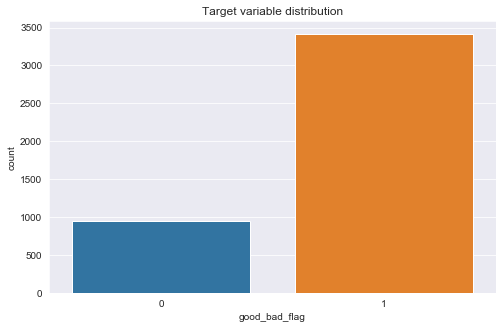

In [1331]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["good_bad_flag"])
plt.title('Target variable distribution')
plt.show()

In [1332]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

In [1333]:
# Label encode categorical variables
for col in cat_cols:
  # Instantiate Labelencoder
  le = LabelEncoder()
  train[col] = le.fit_transform(train[col])
  test[col] = le.fit_transform(test[col])  

train.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,30000.00000,34500.00000,30,459,1972-01-15,...,2016-08-15 18:22:40.000000000,2016-08-15 17:22:32.000000000,10000.00000,13000.00000,30.00000,2016-09-01 16:06:48.000000000,459,2016-09-14 00:00:00.000000000,2016-09-01 15:51:43.000000000,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,15000.00000,17250.00000,30,459,1985-08-23,...,2017-04-13 23:36:56.868777216,2017-04-13 22:33:01.322321664,13002.75292,15741.81289,25.36820,2017-05-07 11:51:18.843083264,459,2017-05-08 17:22:55.086028800,2017-05-07 01:11:13.818306816,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,20000.00000,22250.00000,15,459,1984-09-18,...,2017-04-09 18:25:55.000000000,2017-04-09 17:25:42.000000000,10000.00000,11500.00000,15.00000,2017-04-24 01:35:52.000000000,459,2017-04-24 00:00:00.000000000,2017-04-24 00:48:43.000000000,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,10000.00000,11500.00000,15,459,1977-10-10,...,2017-06-17 09:29:57.000000000,2017-06-17 08:29:50.000000000,10000.00000,11500.00000,15.00000,2017-07-14 21:18:43.000000000,459,2017-07-03 00:00:00.000000000,2017-07-14 21:08:35.000000000,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,40000.00000,44000.00000,30,459,1986-09-07,...,2017-03-06 13:25:17.000000000,2017-03-06 12:25:10.000000000,20000.00000,23800.00000,30.00000,2017-04-04 15:46:56.000000000,459,2017-04-05 00:00:00.000000000,2017-04-04 15:31:47.000000000,1


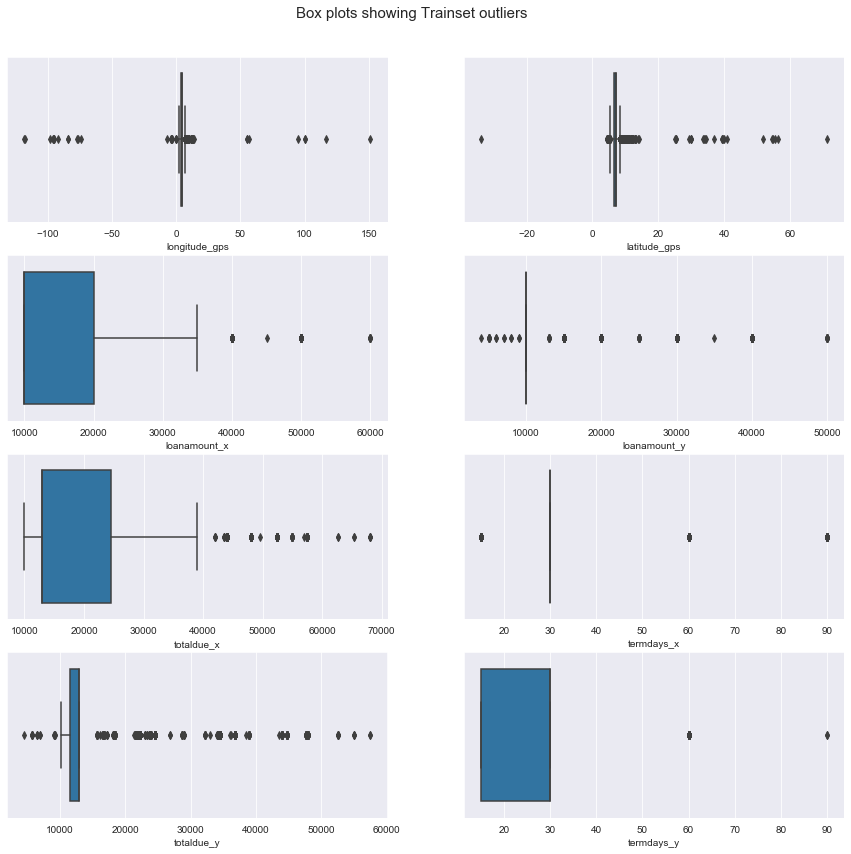

In [1334]:
# Plotting boxplots for each of the numerical Train Dataset columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 14))
fig.suptitle('Box plots showing Trainset outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['longitude_gps',	'latitude_gps','loanamount_x','loanamount_y','totaldue_x','termdays_x','totaldue_y','termdays_y','good_bad_flag']):
  sns.boxplot(train[name], ax = ax)

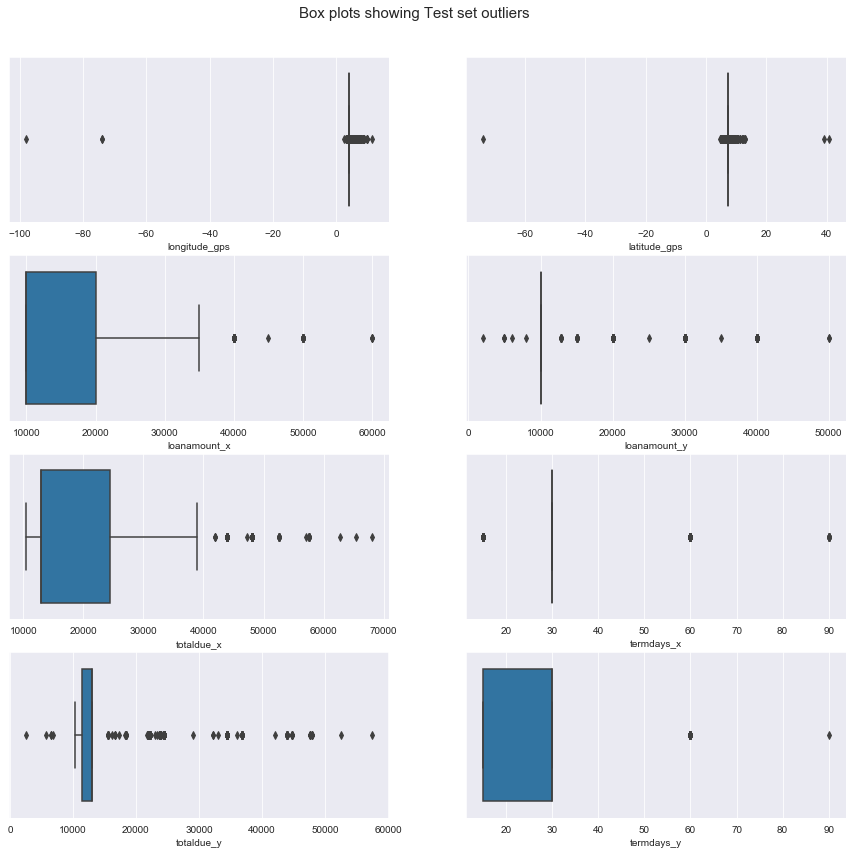

In [1335]:
# Plotting boxplots for each of the numerical Test Dataset columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 4, ncols = 2, figsize = (15, 14))
fig.suptitle('Box plots showing Test set outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), test, ['longitude_gps',	'latitude_gps','loanamount_x','loanamount_y','totaldue_x','termdays_x','totaldue_y','termdays_y','good_bad_flag']):
  sns.boxplot(test[name], ax = ax)

In [1336]:
rob_scaler = RobustScaler()
min_scaler = MinMaxScaler()

train[['loanamount_x','loanamount_y']] = min_scaler.fit_transform(train[['loanamount_x','loanamount_y']])
test[['loanamount_x','loanamount_y']] = min_scaler.fit_transform(test[['loanamount_x','loanamount_y']])
train[['longitude_gps',	'latitude_gps','loanamount_x','loanamount_y','totaldue_x','termdays_x','totaldue_y','termdays_y']] = rob_scaler.fit_transform(train[['longitude_gps','latitude_gps','loanamount_x','loanamount_y','totaldue_x','termdays_x','totaldue_y','termdays_y']])
test[['longitude_gps','latitude_gps','loanamount_x','loanamount_y','totaldue_x','termdays_x','totaldue_y','termdays_y']] = rob_scaler.fit_transform(test[['longitude_gps','latitude_gps','loanamount_x','loanamount_y','totaldue_x','termdays_x','totaldue_y','termdays_y']])

In [1337]:
train.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,2.00000,1.86957,0.00000,459,1972-01-15,...,2016-08-15 18:22:40.000000000,2016-08-15 17:22:32.000000000,0.00000,0.00000,0.00000,2016-09-01 16:06:48.000000000,459,2016-09-14 00:00:00.000000000,2016-09-01 15:51:43.000000000,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,0.50000,0.36957,0.00000,459,1985-08-23,...,2017-04-13 23:36:56.868777216,2017-04-13 22:33:01.322321664,0.06528,1.82788,-0.30879,2017-05-07 11:51:18.843083264,459,2017-05-08 17:22:55.086028800,2017-05-07 01:11:13.818306816,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,1.00000,0.80435,-15.00000,459,1984-09-18,...,2017-04-09 18:25:55.000000000,2017-04-09 17:25:42.000000000,0.00000,-1.00000,-1.00000,2017-04-24 01:35:52.000000000,459,2017-04-24 00:00:00.000000000,2017-04-24 00:48:43.000000000,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,0.00000,-0.13043,-15.00000,459,1977-10-10,...,2017-06-17 09:29:57.000000000,2017-06-17 08:29:50.000000000,0.00000,-1.00000,-1.00000,2017-07-14 21:18:43.000000000,459,2017-07-03 00:00:00.000000000,2017-07-14 21:08:35.000000000,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,3.00000,2.69565,0.00000,459,1986-09-07,...,2017-03-06 13:25:17.000000000,2017-03-06 12:25:10.000000000,0.21739,7.20000,0.00000,2017-04-04 15:46:56.000000000,459,2017-04-05 00:00:00.000000000,2017-04-04 15:31:47.000000000,1


D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\statsmodels\nonparametric\kde.py:487: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\statsmodels\nonparametric\kde.py:487: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

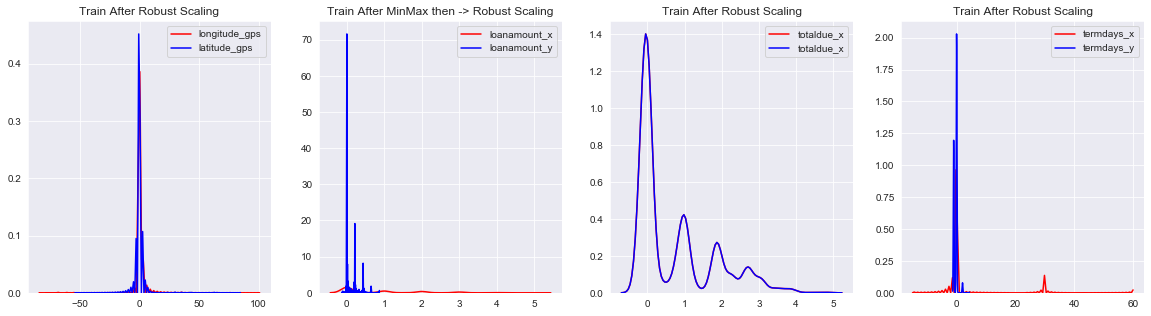

In [1338]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))

ax1.set_title('Train After Robust Scaling')
sns.kdeplot(train['longitude_gps'], ax = ax1, color ='r')
sns.kdeplot(train['latitude_gps'], ax = ax1, color ='b')

ax2.set_title('Train After MinMax then -> Robust Scaling')
sns.kdeplot(train['loanamount_x'], ax = ax2, color ='red')
sns.kdeplot(train['loanamount_y'], ax = ax2, color ='blue')

ax3.set_title('Train After Robust Scaling')
sns.kdeplot(train['totaldue_x'], ax = ax3, color ='r')
sns.kdeplot(train['totaldue_x'], ax = ax3, color ='b')

ax4.set_title('Train After Robust Scaling')
sns.kdeplot(train['termdays_x'], ax = ax4, color ='red')
sns.kdeplot(train['termdays_y'], ax = ax4, color ='blue')

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\statsmodels\nonparametric\kde.py:487: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\statsmodels\nonparametric\kde.py:487: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.htm

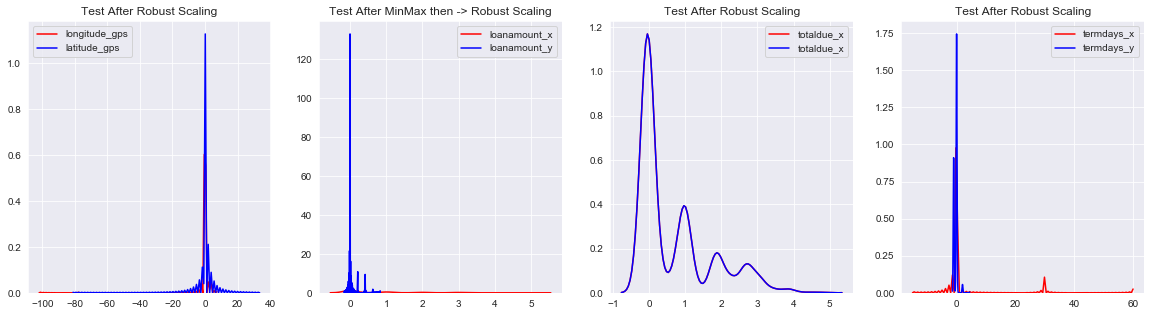

In [1339]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))

ax1.set_title('Test After Robust Scaling')
sns.kdeplot(test['longitude_gps'], ax = ax1, color ='r')
sns.kdeplot(test['latitude_gps'], ax = ax1, color ='b')

ax2.set_title('Test After MinMax then -> Robust Scaling')
sns.kdeplot(test['loanamount_x'], ax = ax2, color ='red')
sns.kdeplot(test['loanamount_y'], ax = ax2, color ='blue')

ax3.set_title('Test After Robust Scaling')
sns.kdeplot(test['totaldue_x'], ax = ax3, color ='r')
sns.kdeplot(test['totaldue_x'], ax = ax3, color ='b')

ax4.set_title('Test After Robust Scaling')
sns.kdeplot(test['termdays_x'], ax = ax4, color ='red')
sns.kdeplot(test['termdays_y'], ax = ax4, color ='blue')

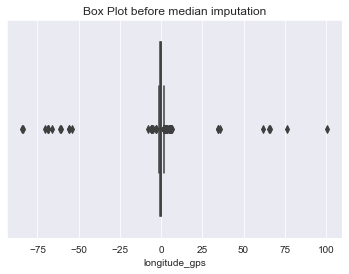

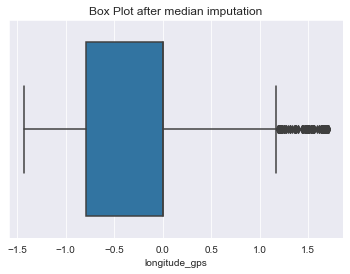

In [1340]:
# DEALING WITH OUTLIERS IN TRAIN SET

#median imputation for longitude_gps
sns.boxplot(train['longitude_gps'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['longitude_gps'].quantile(0.25)
q3 = train['longitude_gps'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['longitude_gps'])
for i in train['longitude_gps']:
    if i > Upper_tail or i < Lower_tail:
            train['longitude_gps'] = train['longitude_gps'].replace(i, med)
sns.boxplot(train['longitude_gps'])
plt.title("Box Plot after median imputation")
plt.show()   

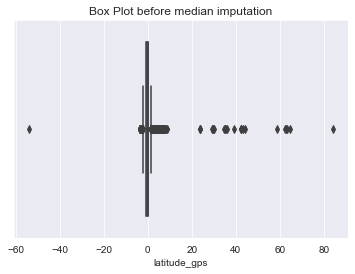

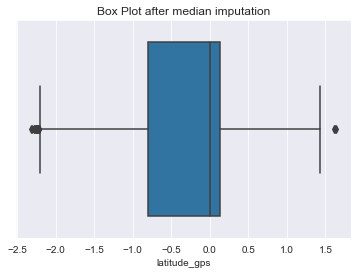

In [1341]:
#median imputation for latitude_gps
sns.boxplot(train['latitude_gps'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['latitude_gps'].quantile(0.25)
q3 = train['latitude_gps'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['latitude_gps'])
for i in train['latitude_gps']:
    if i > Upper_tail or i < Lower_tail:
            train['latitude_gps'] = train['latitude_gps'].replace(i, med)
sns.boxplot(train['latitude_gps'])
plt.title("Box Plot after median imputation")
plt.show() 

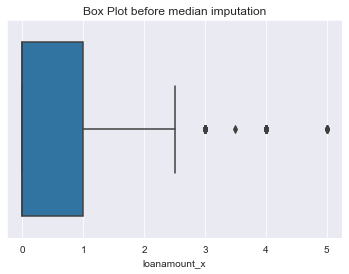

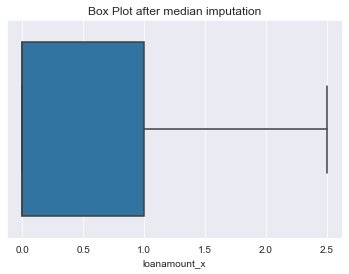

In [1342]:
#median imputation for loanamount_x
sns.boxplot(train['loanamount_x'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['loanamount_x'].quantile(0.25)
q3 = train['loanamount_x'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['loanamount_x'])
for i in train['loanamount_x']:
    if i > Upper_tail or i < Lower_tail:
            train['loanamount_x'] = train['loanamount_x'].replace(i, med)
sns.boxplot(train['loanamount_x'])
plt.title("Box Plot after median imputation")
plt.show() 

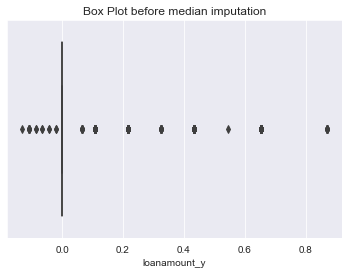

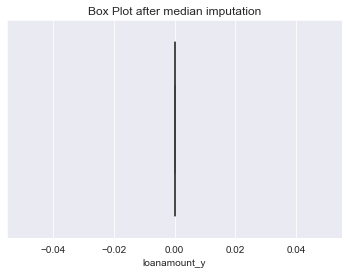

In [1343]:
#median imputation for loanamount_y
sns.boxplot(train['loanamount_y'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['loanamount_y'].quantile(0.25)
q3 = train['loanamount_y'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['loanamount_y'])
for i in train['loanamount_y']:
    if i > Upper_tail or i < Lower_tail:
            train['loanamount_y'] = train['loanamount_y'].replace(i, med)
sns.boxplot(train['loanamount_y'])
plt.title("Box Plot after median imputation")
plt.show()

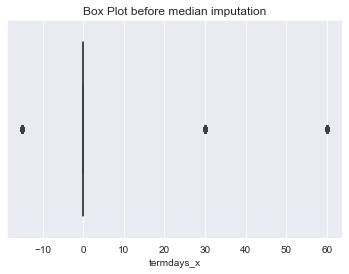

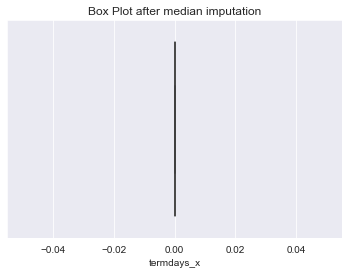

In [1344]:
#median imputation for termdays_x
sns.boxplot(train['termdays_x'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['termdays_x'].quantile(0.25)
q3 = train['termdays_x'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['termdays_x'])
for i in train['termdays_x']:
    if i > Upper_tail or i < Lower_tail:
            train['termdays_x'] = train['termdays_x'].replace(i, med)
sns.boxplot(train['termdays_x'])
plt.title("Box Plot after median imputation")
plt.show()

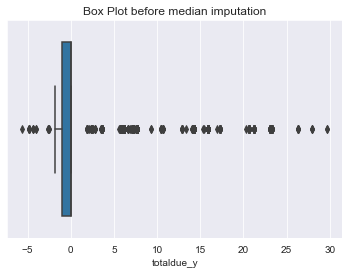

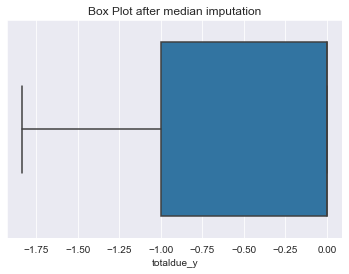

In [1345]:
#median imputation for totaldue_x
sns.boxplot(train['totaldue_y'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['totaldue_y'].quantile(0.25)
q3 = train['totaldue_y'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['totaldue_y'])
for i in train['totaldue_y']:
    if i > Upper_tail or i < Lower_tail:
            train['totaldue_y'] = train['totaldue_y'].replace(i, med)
sns.boxplot(train['totaldue_y'])
plt.title("Box Plot after median imputation")
plt.show()

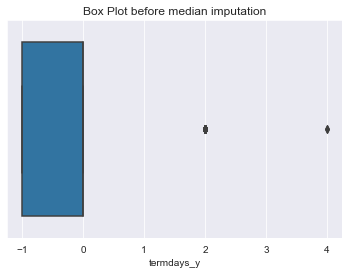

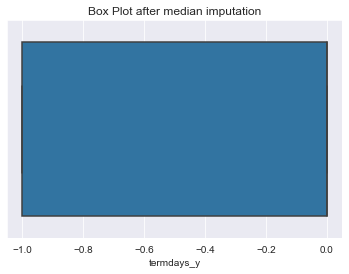

In [1346]:
#median imputation for termdays_y
sns.boxplot(train['termdays_y'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = train['termdays_y'].quantile(0.25)
q3 = train['termdays_y'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(train['termdays_y'])
for i in train['termdays_y']:
    if i > Upper_tail or i < Lower_tail:
            train['termdays_y'] = train['termdays_y'].replace(i, med)
sns.boxplot(train['termdays_y'])
plt.title("Box Plot after median imputation")
plt.show()

In [1347]:
# //////////////////////////////////////////////////////////////////////////////////////////////////////////

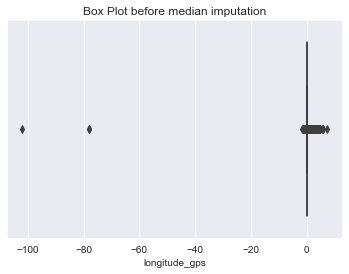

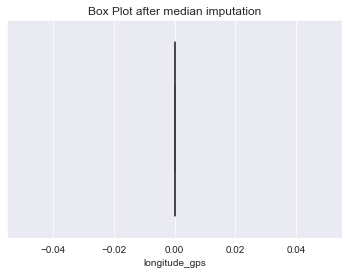

In [1348]:
# DEALING WITH OUTLIERS IN TEST SET

#median imputation for longitude_gps
sns.boxplot(test['longitude_gps'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['longitude_gps'].quantile(0.25)
q3 = test['longitude_gps'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['longitude_gps'])
for i in test['longitude_gps']:
    if i > Upper_tail or i < Lower_tail:
            test['longitude_gps'] = test['longitude_gps'].replace(i, med)
sns.boxplot(test['longitude_gps'])
plt.title("Box Plot after median imputation")
plt.show()   

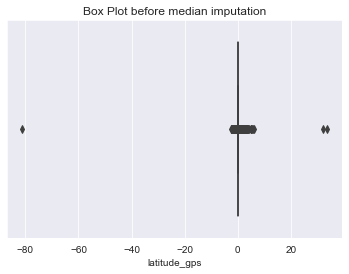

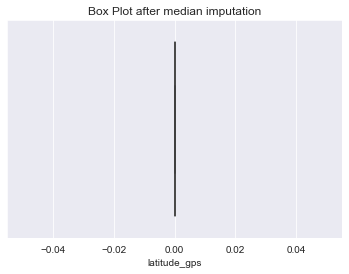

In [1349]:
#median imputation for latitude_gps
sns.boxplot(test['latitude_gps'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['latitude_gps'].quantile(0.25)
q3 = test['latitude_gps'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['latitude_gps'])
for i in test['latitude_gps']:
    if i > Upper_tail or i < Lower_tail:
            test['latitude_gps'] = test['latitude_gps'].replace(i, med)
sns.boxplot(test['latitude_gps'])
plt.title("Box Plot after median imputation")
plt.show() 

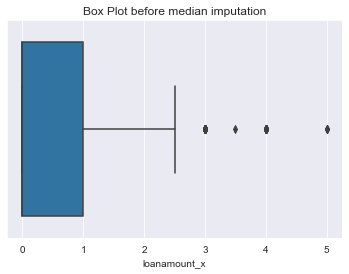

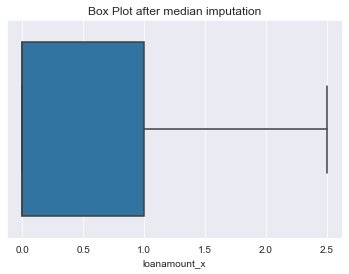

In [1350]:
#median imputation for loanamount_x
sns.boxplot(test['loanamount_x'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['loanamount_x'].quantile(0.25)
q3 = test['loanamount_x'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['loanamount_x'])
for i in test['loanamount_x']:
    if i > Upper_tail or i < Lower_tail:
            test['loanamount_x'] = test['loanamount_x'].replace(i, med)
sns.boxplot(test['loanamount_x'])
plt.title("Box Plot after median imputation")
plt.show() 

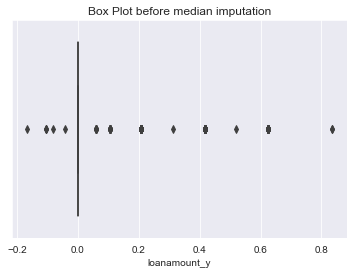

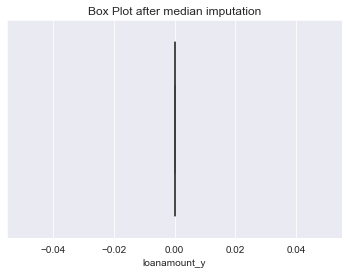

In [1351]:
#median imputation for loanamount_x
sns.boxplot(test['loanamount_y'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['loanamount_y'].quantile(0.25)
q3 = test['loanamount_y'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['loanamount_y'])
for i in test['loanamount_y']:
    if i > Upper_tail or i < Lower_tail:
            test['loanamount_y'] = test['loanamount_y'].replace(i, med)
sns.boxplot(test['loanamount_y'])
plt.title("Box Plot after median imputation")
plt.show()

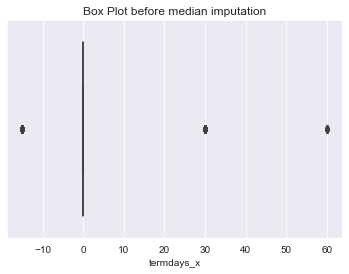

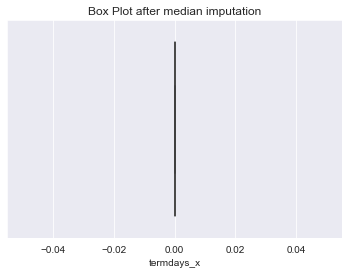

In [1352]:
#median imputation for termdays_x
sns.boxplot(test['termdays_x'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['termdays_x'].quantile(0.25)
q3 = test['termdays_x'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['termdays_x'])
for i in test['termdays_x']:
    if i > Upper_tail or i < Lower_tail:
            test['termdays_x'] = test['termdays_x'].replace(i, med)
sns.boxplot(test['termdays_x'])
plt.title("Box Plot after median imputation")
plt.show()

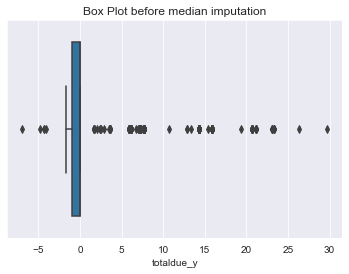

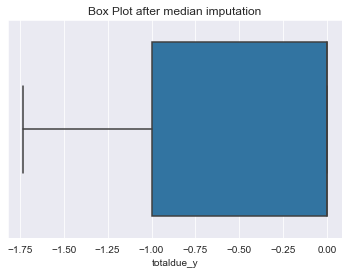

In [1353]:
#median imputation for totaldue_x
sns.boxplot(test['totaldue_y'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['totaldue_y'].quantile(0.25)
q3 = test['totaldue_y'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['totaldue_y'])
for i in test['totaldue_y']:
    if i > Upper_tail or i < Lower_tail:
            test['totaldue_y'] = test['totaldue_y'].replace(i, med)
sns.boxplot(test['totaldue_y'])
plt.title("Box Plot after median imputation")
plt.show()

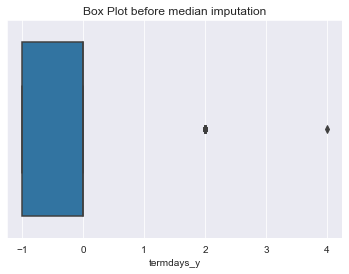

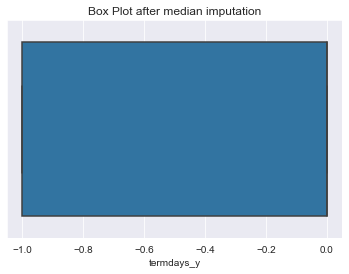

In [1354]:
#median imputation for termdays_y
sns.boxplot(test['termdays_y'])
plt.title("Box Plot before median imputation")
plt.show()
q1 = test['termdays_y'].quantile(0.25)
q3 = test['termdays_y'].quantile(0.75)
iqr = q3-q1
Lower_tail = q1 - 1.5 * iqr
Upper_tail = q3 + 1.5 * iqr
med = np.median(test['termdays_y'])
for i in test['termdays_y']:
    if i > Upper_tail or i < Lower_tail:
            test['termdays_y'] = test['termdays_y'].replace(i, med)
sns.boxplot(test['termdays_y'])
plt.title("Box Plot after median imputation")
plt.show()

In [1355]:
# ///////////////////////////////////////////////////////////////////////////////////////////////////////////
# FEATURE ENGINEERING

In [1356]:
train.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,approveddate_y,creationdate_y,loanamount_y,totaldue_y,termdays_y,closeddate,referredby_y,firstduedate,firstrepaiddate,good_bad_flag
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2017-07-25 08:22:56,2017-07-25 07:22:47,2.00000,1.86957,0.00000,459,1972-01-15,...,2016-08-15 18:22:40.000000000,2016-08-15 17:22:32.000000000,0.00000,0.00000,0.00000,2016-09-01 16:06:48.000000000,459,2016-09-14 00:00:00.000000000,2016-09-01 15:51:43.000000000,1
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,2017-07-05 17:04:41,2017-07-05 16:04:18,0.50000,0.36957,0.00000,459,1985-08-23,...,2017-04-13 23:36:56.868777216,2017-04-13 22:33:01.322321664,0.00000,0.00000,-0.30879,2017-05-07 11:51:18.843083264,459,2017-05-08 17:22:55.086028800,2017-05-07 01:11:13.818306816,1
2,8a8588f35438fe12015444567666018e,301966580,7,2017-07-06 14:52:57,2017-07-06 13:52:51,1.00000,0.80435,0.00000,459,1984-09-18,...,2017-04-09 18:25:55.000000000,2017-04-09 17:25:42.000000000,0.00000,-1.00000,-1.00000,2017-04-24 01:35:52.000000000,459,2017-04-24 00:00:00.000000000,2017-04-24 00:48:43.000000000,1
3,8a85890754145ace015429211b513e16,301999343,3,2017-07-27 19:00:41,2017-07-27 18:00:35,0.00000,-0.13043,0.00000,459,1977-10-10,...,2017-06-17 09:29:57.000000000,2017-06-17 08:29:50.000000000,0.00000,-1.00000,-1.00000,2017-07-14 21:18:43.000000000,459,2017-07-03 00:00:00.000000000,2017-07-14 21:08:35.000000000,1
4,8a858970548359cc0154883481981866,301962360,9,2017-07-03 23:42:45,2017-07-03 22:42:39,0.00000,2.69565,0.00000,459,1986-09-07,...,2017-03-06 13:25:17.000000000,2017-03-06 12:25:10.000000000,0.00000,0.00000,0.00000,2017-04-04 15:46:56.000000000,459,2017-04-05 00:00:00.000000000,2017-04-04 15:31:47.000000000,1


In [1357]:
# Extract day, month and year from the dates for Train set
train['birthdate_day'] = train.birthdate.dt.day
train['birthdate_month'] = train.birthdate.dt.month
train['birthdate_year'] = train.birthdate.dt.year

train['approveddate_x_day'] = train.approveddate_x.dt.day
train['approveddate_x_month'] = train.approveddate_x.dt.month
train['approveddate_x_year'] = train.approveddate_x.dt.year

train['approveddate_y_day'] = train.approveddate_y.dt.day
train['approveddate_y_month'] = train.approveddate_y.dt.month
train['approveddate_y_year'] = train.approveddate_y.dt.year

train['creationdate_x_day'] = train.creationdate_x.dt.day
train['creationdate_x_month'] = train.creationdate_x.dt.month
train['creationdate_x_year'] = train.creationdate_x.dt.year

train['creationdate_y_day'] = train.creationdate_y.dt.day
train['creationdate_y_month'] = train.creationdate_y.dt.month
train['creationdate_y_year'] = train.creationdate_y.dt.year

train['closeddate_day'] = train.closeddate.dt.day
train['closeddate_month'] = train.closeddate.dt.month
train['closeddate_year'] = train.closeddate.dt.year

train['firstduedate_day'] = train.firstduedate.dt.day
train['firstduedate_month'] = train.firstduedate.dt.month
train['firstduedate_year'] = train.firstduedate.dt.year

train['firstrepaiddate_day'] = train.firstrepaiddate.dt.day
train['firstrepaiddate_month'] = train.firstrepaiddate.dt.month
train['firstrepaiddate_year'] = train.firstrepaiddate.dt.year

In [1358]:
# Extract day, month and year from the dates for Test set
test['birthdate_day'] = test.birthdate.dt.day
test['birthdate_month'] = test.birthdate.dt.month
test['birthdate_year'] = test.birthdate.dt.year

test['approveddate_x_day'] = test.approveddate_x.dt.day
test['approveddate_x_month'] = test.approveddate_x.dt.month
test['approveddate_x_year'] = test.approveddate_x.dt.year

test['approveddate_y_day'] = test.approveddate_y.dt.day
test['approveddate_y_month'] = test.approveddate_y.dt.month
test['approveddate_y_year'] = test.approveddate_y.dt.year

test['creationdate_x_day'] = test.creationdate_x.dt.day
test['creationdate_x_month'] = test.creationdate_x.dt.month
test['creationdate_x_year'] = test.creationdate_x.dt.year

test['creationdate_y_day'] = test.creationdate_y.dt.day
test['creationdate_y_month'] = test.creationdate_y.dt.month
test['creationdate_y_year'] = test.creationdate_y.dt.year

test['closeddate_day'] = test.closeddate.dt.day
test['closeddate_month'] = test.closeddate.dt.month
test['closeddate_year'] = test.closeddate.dt.year

test['firstduedate_day'] = test.firstduedate.dt.day
test['firstduedate_month'] = test.firstduedate.dt.month
test['firstduedate_year'] = test.firstduedate.dt.year

test['firstrepaiddate_day'] = test.firstrepaiddate.dt.day
test['firstrepaiddate_month'] = test.firstrepaiddate.dt.month
test['firstrepaiddate_year'] = test.firstrepaiddate.dt.year

In [1359]:
test.head()

,customerid,systemloanid_x,loannumber_x,approveddate_x,creationdate_x,loanamount_x,totaldue_x,termdays_x,referredby_x,birthdate,...,creationdate_y_year,closeddate_day,closeddate_month,closeddate_year,firstduedate_day,firstduedate_month,firstduedate_year,firstrepaiddate_day,firstrepaiddate_month,firstrepaiddate_year
0,8a858899538ddb8e015390510b321f08,301998974,4,2022-04-17 11:34:02.010050304,2022-04-17 11:39:37.461928960,0.00000,-0.06522,0.00000,125,1984-11-16 17:38:29.610389632,...,2016,17,6,2016,16,6,2016,16,6,2016
1,8a858959537a097401537a4e316e25f7,301963615,10,2022-04-17 11:34:02.010050304,2022-04-17 11:39:37.461928960,0.00000,2.69565,0.00000,125,1984-11-16 17:38:29.610389632,...,2017,2,3,2017,6,3,2017,2,3,2017
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,2022-04-17 15:11:00.000000000,2022-04-17 15:04:00.000000000,1.00000,1.00000,0.00000,125,1981-09-05 00:00:00.000000000,...,2016,4,7,2016,4,7,2016,4,7,2016
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,2022-04-17 00:54:00.000000000,2022-04-17 00:49:00.000000000,2.00000,1.86957,0.00000,125,1984-11-16 17:38:29.610389632,...,2017,13,6,2017,14,6,2017,13,6,2017
4,8a858e225a28c713015a30db5c48383d,301959177,4,2022-04-17 04:33:00.000000000,2022-04-17 04:27:00.000000000,1.00000,1.00000,0.00000,125,1975-08-25 00:00:00.000000000,...,2017,1,7,2017,5,7,2017,1,7,2017


In [1360]:
for dataset in (train,test):
    dataset.drop(['birthdate','approveddate_x','creationdate_x','approveddate_y','creationdate_y','closeddate','firstduedate','firstrepaiddate'],axis=1,inplace=True)

In [1361]:
test.head()

,customerid,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,termdays_x,referredby_x,bank_account_type,longitude_gps,latitude_gps,...,creationdate_y_year,closeddate_day,closeddate_month,closeddate_year,firstduedate_day,firstduedate_month,firstduedate_year,firstrepaiddate_day,firstrepaiddate_month,firstrepaiddate_year
0,8a858899538ddb8e015390510b321f08,301998974,4,0.00000,-0.06522,0.00000,125,2,0.00000,0.00000,...,2016,17,6,2016,16,6,2016,16,6,2016
1,8a858959537a097401537a4e316e25f7,301963615,10,0.00000,2.69565,0.00000,125,2,0.00000,0.00000,...,2017,2,3,2017,6,3,2017,2,3,2017
2,8a8589c253ace09b0153af6ba58f1f31,301982236,6,1.00000,1.00000,0.00000,125,2,0.00000,0.00000,...,2016,4,7,2016,4,7,2016,4,7,2016
3,8a858e095aae82b7015aae86ca1e030b,301971730,8,2.00000,1.86957,0.00000,125,2,0.00000,0.00000,...,2017,13,6,2017,14,6,2017,13,6,2017
4,8a858e225a28c713015a30db5c48383d,301959177,4,1.00000,1.00000,0.00000,125,2,0.00000,0.00000,...,2017,1,7,2017,5,7,2017,1,7,2017


In [1362]:
train.corr()['good_bad_flag'].sort_values(ascending=False)

good_bad_flag                 1.00000
totaldue_x                    0.10836
loannumber_x                  0.09049
loanamount_x                  0.08877
loannumber_y                  0.07887
totaldue_y                    0.02461
employment_status_clients     0.01705
firstduedate_day              0.01620
termdays_y                    0.01556
creationdate_y_day            0.01467
approveddate_y_day            0.01376
referredby_y                  0.01309
referredby_x                  0.01309
creationdate_x_day            0.00808
approveddate_x_day            0.00774
bank_branch_clients           0.00737
systemloanid_x                0.00705
approveddate_y_year           0.00069
creationdate_y_year           0.00069
firstduedate_month            0.00059
systemloanid_y               -0.00042
firstduedate_year            -0.00367
bank_name_clients            -0.00403
closeddate_month             -0.00526
closeddate_day               -0.00587
firstrepaiddate_day          -0.00654
level_of_edu

In [1363]:
# Dropping columns with no or very less correlation with the target(good_bad_flag) variable
for dataset in (train,test):
    dataset.drop(['creationdate_y_day','approveddate_y_day','firstrepaiddate_day','closeddate_day','approveddate_y_month','creationdate_y_month','firstduedate_day','firstduedate_month','firstrepaiddate_month','closeddate_month','termdays_x','approveddate_x_month','approveddate_x_year','creationdate_x_month','creationdate_x_year'],axis=1,inplace=True)

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\matrix.py:70: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros(data.shape, np.bool)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\matrix.py:80: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.bool)
D:\CRASHOVERRIDE\SOFTWARES\INS

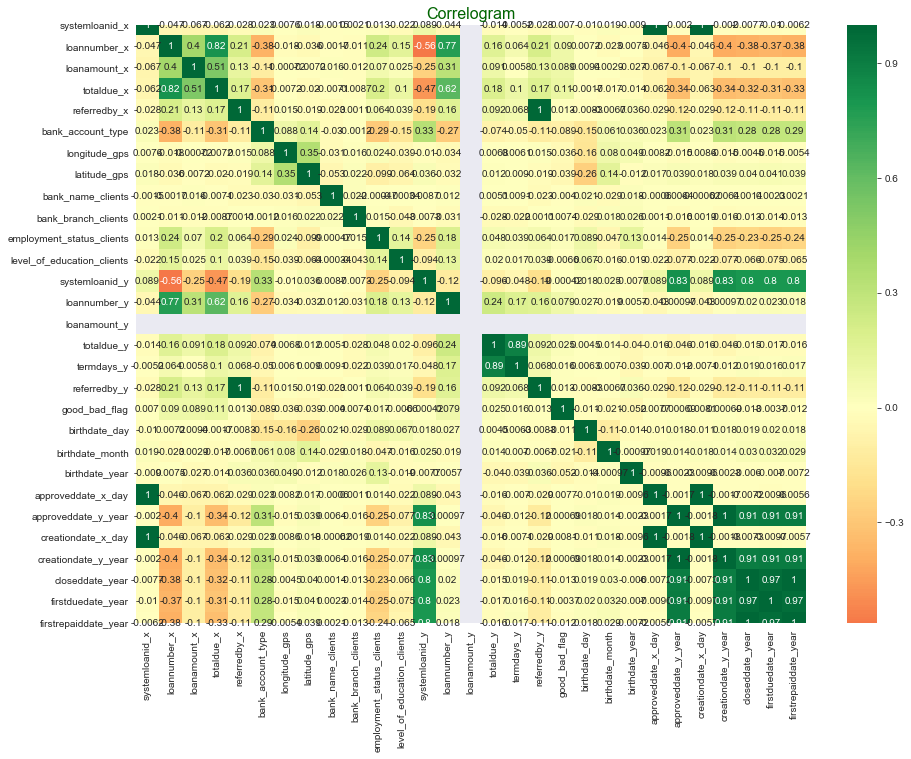

In [1364]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (15, 11))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 16, color = 'darkgreen')
plt.show()

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\axisgrid.py:1530: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data[col].astype(np.float)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\axisgrid.py:1530: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data[col].astype(np.float)
D:\CRASHOV

<Figure size 1440x864 with 0 Axes>

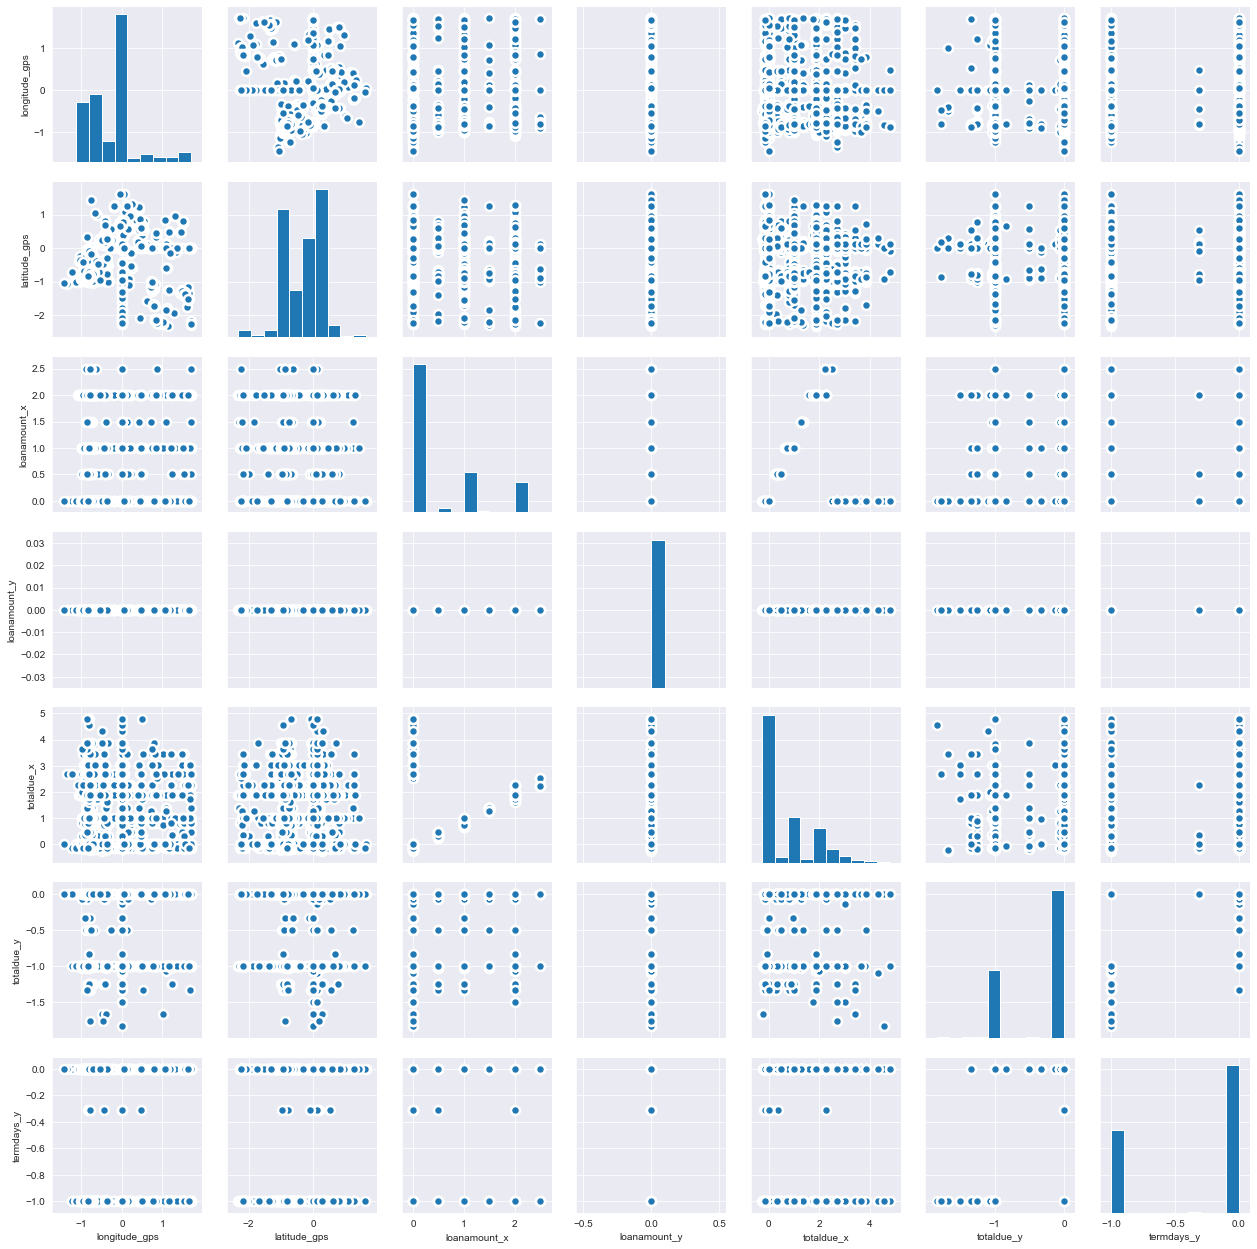

In [1365]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['longitude_gps','latitude_gps','loanamount_x','loanamount_y','totaldue_x','totaldue_y','termdays_y']
sns.pairplot(train[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

In [1366]:
# MODELLING
# //////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1367]:
train.head()

,customerid,systemloanid_x,loannumber_x,loanamount_x,totaldue_x,referredby_x,bank_account_type,longitude_gps,latitude_gps,bank_name_clients,...,birthdate_day,birthdate_month,birthdate_year,approveddate_x_day,approveddate_y_year,creationdate_x_day,creationdate_y_year,closeddate_year,firstduedate_year,firstrepaiddate_year
0,8a2a81a74ce8c05d014cfb32a0da1049,301994762,12,2.00000,1.86957,459,1,-0.75205,-0.99598,1,...,15,1,1972,25,2016,25,2016,2016,2016,2016
1,8a85886e54beabf90154c0a29ae757c0,301965204,2,0.50000,0.36957,459,2,-0.44158,0.17197,6,...,23,8,1985,5,2017,5,2017,2017,2017,2017
2,8a8588f35438fe12015444567666018e,301966580,7,1.00000,0.80435,459,1,0.00000,0.00000,2,...,18,9,1984,6,2017,6,2017,2017,2017,2017
3,8a85890754145ace015429211b513e16,301999343,3,0.00000,-0.13043,459,2,-0.37276,0.39698,5,...,10,10,1977,27,2017,27,2017,2017,2017,2017
4,8a858970548359cc0154883481981866,301962360,9,0.00000,2.69565,459,1,0.00000,0.00000,6,...,7,9,1986,3,2017,3,2017,2017,2017,2017


D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


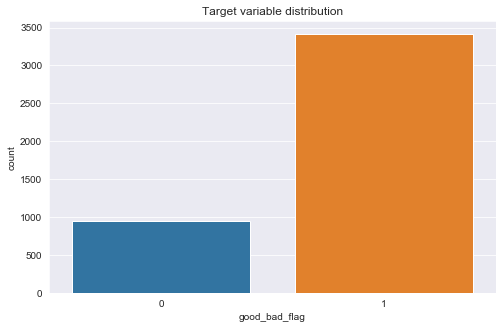

In [1368]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["good_bad_flag"])
plt.title('Target variable distribution')
plt.show()

In [1369]:
for col in train.columns:
    print(col)

customerid
systemloanid_x
loannumber_x
loanamount_x
totaldue_x
referredby_x
bank_account_type
longitude_gps
latitude_gps
bank_name_clients
bank_branch_clients
employment_status_clients
level_of_education_clients
systemloanid_y
loannumber_y
loanamount_y
totaldue_y
termdays_y
referredby_y
good_bad_flag
birthdate_day
birthdate_month
birthdate_year
approveddate_x_day
approveddate_y_year
creationdate_x_day
creationdate_y_year
closeddate_year
firstduedate_year
firstrepaiddate_year


In [1370]:
# Selecting the independent variables and the target variable
train_feats = ['bank_account_type','longitude_gps','latitude_gps','bank_name_clients','bank_branch_clients',\
'level_of_education_clients','systemloanid_x','loannumber_x','loanamount_x',\
'totaldue_x','referredby_x','systemloanid_y','loannumber_y','totaldue_y','termdays_y',\
'referredby_y','birthdate_day','birthdate_month','birthdate_year','approveddate_x_day','approveddate_y_year',\
'creationdate_x_day','creationdate_y_year']

X = train[train_feats]
y = train.good_bad_flag

In [1371]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [1372]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3057, 23), (1311, 23), (3057,), (1311,))

In [1373]:
# !pip install imblearn

In [1374]:
from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.combine import SMOTEENN

In [1375]:
counter = Counter(y_train)
print('Before',counter)
# oversampling the train dataset using SMOTE + ENN
smenn = SMOTEENN()
X_train_smenn, y_train_smenn = smenn.fit_resample(X_train, y_train)

counter = Counter(y_train_smenn)
print('After',counter)

Before Counter({1: 2398, 0: 659})
After Counter({0: 1083, 1: 852})


In [1376]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [1377]:
from catboost import CatBoostClassifier
errcb2=[]
y_pred_totcb2=[]
from sklearn.model_selection import KFold,StratifiedKFold, TimeSeriesSplit
from sklearn.metrics import accuracy_score
fold=StratifiedKFold(n_splits=10)#15#5#10
i=1
for train_index, test_index in fold.split(X,y):
    X_train_smenn, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train_smenn, y_test = y.iloc[train_index], y.iloc[test_index]
    m2  = CatBoostClassifier(n_estimators=800,eval_metric='Accuracy',od_wait=200, learning_rate=0.2,
                              bootstrap_type='Bernoulli',metric_period=100,max_depth = 8,
                     use_best_model=True)
    m2.fit(X_train_smenn,y_train_smenn,eval_set=[(X_train_smenn,y_train_smenn),(X_test, y_test)], early_stopping_rounds=200,verbose=100,)
    preds=m2.predict(X_test)
    print("Accuracy: ",(accuracy_score(y_test,preds)))
    errcb2.append((accuracy_score(y_test,preds)))
    p2 = m2.predict(test_df)
    y_pred_totcb2.append(p2)
np.mean(errcb2)

0:	learn: 0.7822437	test: 0.7822437	test1: 0.7826087	best: 0.7826087 (0)	total: 3.86ms	remaining: 3.08s


100:	learn: 0.9333503	test: 0.9333503	test1: 0.7711670	best: 0.7917620 (31)	total: 821ms	remaining: 5.68s
200:	learn: 0.9832104	test: 0.9832104	test1: 0.7620137	best: 0.7917620 (31)	total: 1.55s	remaining: 4.63s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7917620137
bestIteration = 31

Shrink model to first 32 iterations.
Accuracy:  0.7917620137299771
0:	learn: 0.7822437	test: 0.7822437	test1: 0.7826087	best: 0.7826087 (0)	total: 3.27ms	remaining: 2.61s


100:	learn: 0.9267362	test: 0.9267362	test1: 0.7780320	best: 0.7940503 (71)	total: 744ms	remaining: 5.15s
200:	learn: 0.9814297	test: 0.9814297	test1: 0.7574371	best: 0.7940503 (71)	total: 1.55s	remaining: 4.62s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7940503432
bestIteration = 71

Shrink model to first 72 iterations.
Accuracy:  0.7940503432494279
0:	learn: 0.7822437	test: 0.7822437	test1: 0.7826087	best: 0.7826087 (0)	total: 3.3ms	remaining: 2.64s


100:	learn: 0.9295345	test: 0.9295345	test1: 0.7643021	best: 0.7894737 (30)	total: 821ms	remaining: 5.68s
200:	learn: 0.9796489	test: 0.9796489	test1: 0.7620137	best: 0.7894737 (30)	total: 1.64s	remaining: 4.88s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7894736842
bestIteration = 30

Shrink model to first 31 iterations.
Accuracy:  0.7894736842105263
0:	learn: 0.7822437	test: 0.7822437	test1: 0.7826087	best: 0.7826087 (0)	total: 4.2ms	remaining: 3.36s


100:	learn: 0.9308064	test: 0.9308064	test1: 0.7597254	best: 0.7826087 (0)	total: 826ms	remaining: 5.72s
200:	learn: 0.9814297	test: 0.9814297	test1: 0.7505721	best: 0.7826087 (0)	total: 1.6s	remaining: 4.77s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7826086957
bestIteration = 0

Shrink model to first 1 iterations.
Accuracy:  0.782608695652174
0:	learn: 0.7819893	test: 0.7819893	test1: 0.7826087	best: 0.7826087 (0)	total: 21.8ms	remaining: 17.5s


100:	learn: 0.9320784	test: 0.9320784	test1: 0.7643021	best: 0.7848970 (18)	total: 820ms	remaining: 5.68s
200:	learn: 0.9819384	test: 0.9819384	test1: 0.7597254	best: 0.7848970 (18)	total: 1.56s	remaining: 4.66s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7848970252
bestIteration = 18

Shrink model to first 19 iterations.
Accuracy:  0.7848970251716247
0:	learn: 0.7819893	test: 0.7819893	test1: 0.7826087	best: 0.7826087 (0)	total: 7.18ms	remaining: 5.74s


100:	learn: 0.9285169	test: 0.9285169	test1: 0.7826087	best: 0.7940503 (40)	total: 759ms	remaining: 5.26s
200:	learn: 0.9816840	test: 0.9816840	test1: 0.7620137	best: 0.7940503 (40)	total: 1.57s	remaining: 4.69s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7940503432
bestIteration = 40

Shrink model to first 41 iterations.
Accuracy:  0.7940503432494279
0:	learn: 0.7824981	test: 0.7824981	test1: 0.7803204	best: 0.7803204 (0)	total: 14ms	remaining: 11.2s


100:	learn: 0.9229204	test: 0.9229204	test1: 0.7757437	best: 0.7917620 (36)	total: 793ms	remaining: 5.49s
200:	learn: 0.9799033	test: 0.9799033	test1: 0.7574371	best: 0.7917620 (36)	total: 1.57s	remaining: 4.69s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7917620137
bestIteration = 36

Shrink model to first 37 iterations.
Accuracy:  0.7917620137299771
0:	learn: 0.7824981	test: 0.7824981	test1: 0.7803204	best: 0.7803204 (0)	total: 31.4ms	remaining: 25.1s


100:	learn: 0.9274994	test: 0.9274994	test1: 0.7803204	best: 0.7826087 (6)	total: 789ms	remaining: 5.46s
200:	learn: 0.9806665	test: 0.9806665	test1: 0.7711670	best: 0.7826087 (6)	total: 1.59s	remaining: 4.75s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7826086957
bestIteration = 6

Shrink model to first 7 iterations.
Accuracy:  0.782608695652174
0:	learn: 0.7822991	test: 0.7822991	test1: 0.7821101	best: 0.7821101 (0)	total: 11.5ms	remaining: 9.18s


100:	learn: 0.9298067	test: 0.9298067	test1: 0.7683486	best: 0.7866972 (11)	total: 821ms	remaining: 5.68s
200:	learn: 0.9811801	test: 0.9811801	test1: 0.7775229	best: 0.7866972 (11)	total: 1.6s	remaining: 4.77s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7866972477
bestIteration = 11

Shrink model to first 12 iterations.
Accuracy:  0.786697247706422
0:	learn: 0.7822991	test: 0.7822991	test1: 0.7798165	best: 0.7798165 (0)	total: 3.35ms	remaining: 2.68s


100:	learn: 0.9280264	test: 0.9280264	test1: 0.7637615	best: 0.7844037 (34)	total: 745ms	remaining: 5.15s
200:	learn: 0.9819430	test: 0.9819430	test1: 0.7683486	best: 0.7844037 (34)	total: 1.52s	remaining: 4.53s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.7844036697
bestIteration = 34

Shrink model to first 35 iterations.
Accuracy:  0.7844036697247706


0.7882313732076501

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\categorical.py:339: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\categorical.py:339: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(s, dtype=np.float)


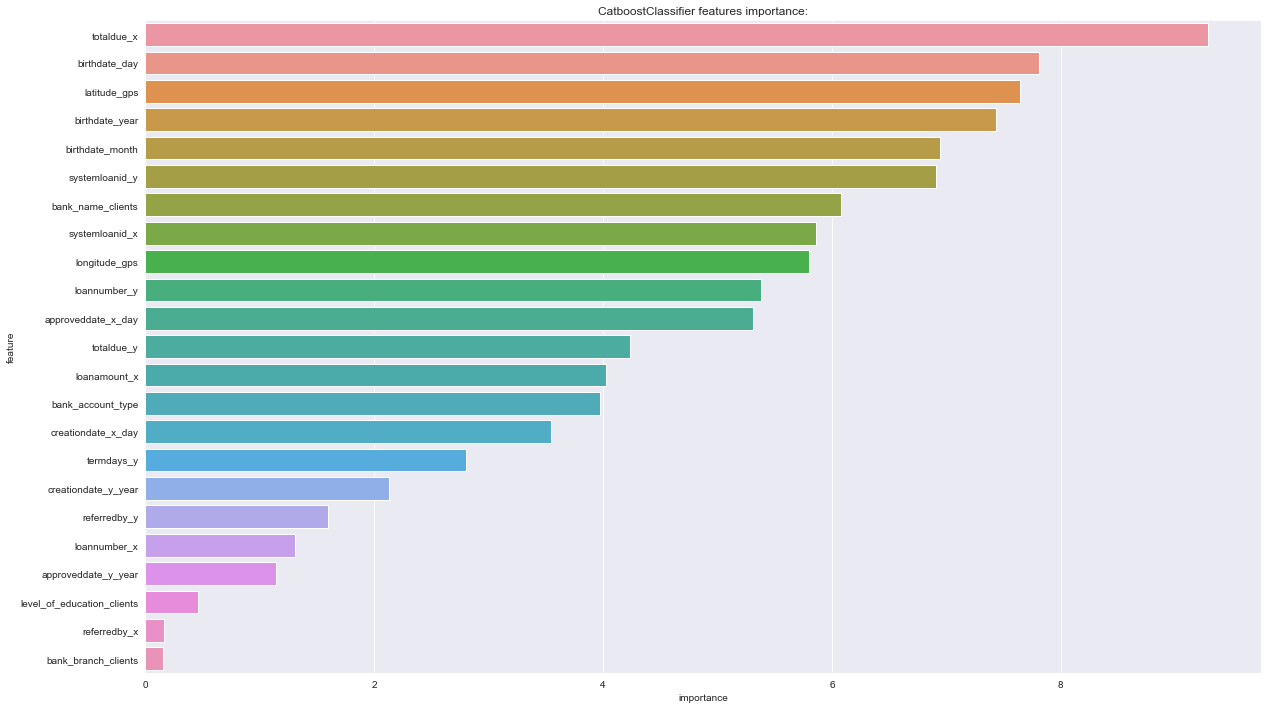

In [1378]:
#0.984
feature_importance_df = pd.DataFrame(m2.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train_smenn.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(50))
plt.title('CatboostClassifier features importance:');

In [1379]:
cat_predictions = pd.DataFrame(y_pred_totcb2)

In [1380]:
cat_predictions = np.where(np.mean(cat_predictions,axis=0)> 0.45, 1, 0)
cat_predictions = cat_predictions.T
cat_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [1381]:
sub = cat_predictions
samplesubmission.Good_Bad_flag = sub

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


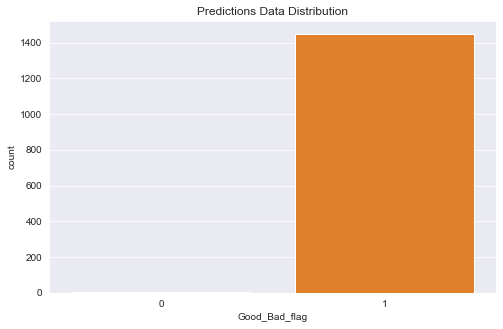

In [1382]:
# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(samplesubmission.Good_Bad_flag)
plt.title('Predictions Data Distribution');

In [1383]:
# Create file
samplesubmission.to_csv('submissions/cat_boost2_submission.csv', index = False)

In [1384]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1385]:
# Model 2: Decision Tree

estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

In [1386]:
#Original unsampled data 

tree_model = DecisionTreeClassifier()

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=5, min_samples_split=10)

In [1387]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

Confusion Matrix
[[ 12  83]
 [ 12 329]] 

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.13      0.20        95
           1       0.80      0.96      0.87       341

    accuracy                           0.78       436
   macro avg       0.65      0.55      0.54       436
weighted avg       0.73      0.78      0.73       436
 

AUC-ROC
0.6656891495601173


In [1388]:
# SMOTE + ENN Resampling

clf_DT.fit(X_train_smenn, y_train_smenn)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=5, min_samples_leaf=5)

In [1389]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'smote+enn')

Confusion Matrix
[[  4  91]
 [  5 336]] 

Classification Report
              precision    recall  f1-score   support

           0       0.44      0.04      0.08        95
           1       0.79      0.99      0.88       341

    accuracy                           0.78       436
   macro avg       0.62      0.51      0.48       436
weighted avg       0.71      0.78      0.70       436
 

AUC-ROC
0.61356690847353


D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


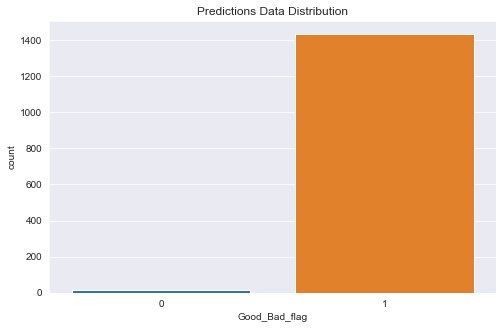

In [1390]:
# Make prediction on the test set
test_df = test[train_feats]
DT_predictions = clf_DT.predict(test_df)

# # Create a submission file
subb_file = samplesubmission.copy()
subb_file['Good_Bad_flag'] = DT_predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(subb_file.Good_Bad_flag)
plt.title('Predictions Data Distribution');

In [1391]:
# Create file
subb_file.to_csv('submissions/DT_SMOTE_submission.csv', index = False)
subb_file.head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [1392]:
# ////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1393]:
# MODEL 3: RANDOM FOREST

# Original Unsampled Data
rf_model = RandomForestClassifier()

rf_params={'n_estimators':estimators,
           'max_depth':max_depth,
           'min_samples_split':min_samples_split}

clf_RF = RandomizedSearchCV(rf_model, rf_params, cv=cv, scoring='roc_auc', n_jobs=-1, n_iter=20, verbose=2)
clf_RF.fit(X_train, y_train)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=7, n_estimators=30)

In [1394]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'actual')

Confusion Matrix
[[  3  92]
 [  0 341]] 

Classification Report
              precision    recall  f1-score   support

           0       1.00      0.03      0.06        95
           1       0.79      1.00      0.88       341

    accuracy                           0.79       436
   macro avg       0.89      0.52      0.47       436
weighted avg       0.83      0.79      0.70       436
 

AUC-ROC
0.8033801512579103


In [1395]:
# SMOTE + ENN Resampling
clf_RF.fit(X_train_smenn, y_train_smenn)
clf_RF.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomForestClassifier(max_depth=7)

In [1396]:
test_eval(clf_RF, X_test, y_test, 'Random Forest', 'smote+enn')

Confusion Matrix
[[  0  95]
 [  0 341]] 

Classification Report
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        95
           1       0.78      1.00      0.88       341

    accuracy                           0.78       436
   macro avg       0.39      0.50      0.44       436
weighted avg       0.61      0.78      0.69       436
 

AUC-ROC
0.6397592221021763


D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


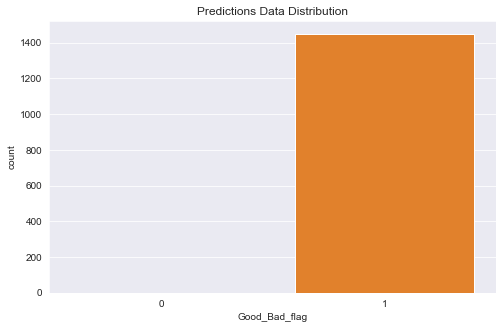

In [1397]:
# Make prediction on the test set
test_df = test[train_feats]
RF_predictions = clf_RF.predict(test_df)

# # Create a submission file
suub_file = samplesubmission.copy()
suub_file['Good_Bad_flag'] = RF_predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(suub_file.Good_Bad_flag)
plt.title('Predictions Data Distribution');

In [1398]:
# Create file
suub_file.to_csv('submissions/RF_SMOTE_submission.csv', index = False)
suub_file.head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [1399]:
# //////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1400]:
# Instantiating the model
clf = RandomForestClassifier(max_depth = 3, random_state = 0)
clf.fit(X_train, y_train)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.7821100917431193


              precision    recall  f1-score   support

           0       0.00      0.00      0.00        95
           1       0.78      1.00      0.88       341

    accuracy                           0.78       436
   macro avg       0.39      0.50      0.44       436
weighted avg       0.61      0.78      0.69       436



D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

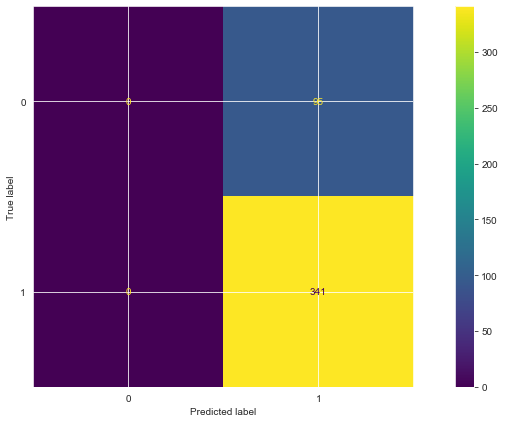

In [1401]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

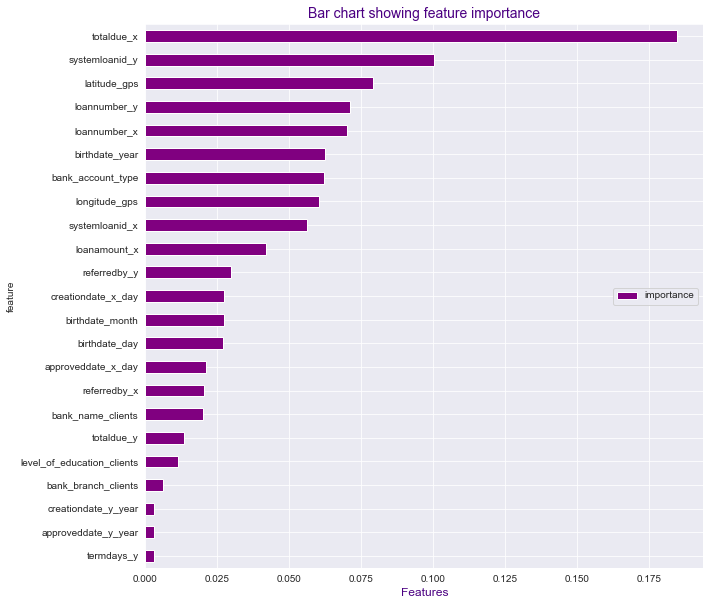

In [1402]:
# Feature importance
impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
impo_df = impo_df[:28].sort_values(by = 'importance', ascending = True)
impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
plt.legend(loc = 'center right')
plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
plt.xlabel('Features', fontsize = 12, color = 'indigo')
plt.show()

In [1403]:
# ///////////////////////////////////////////////////////////////////////////////////////////////////
# Making predictions of the test set and creating a submission
samplesubmission = pd.read_csv('SampleSubmission.csv')

In [1404]:
# Make prediction on the test set
test_df = test[train_feats]
predictions = clf.predict(test_df)

In [1405]:
# # Create a submission file
sub_file = samplesubmission.copy()
sub_file['Good_Bad_flag'] = predictions

D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


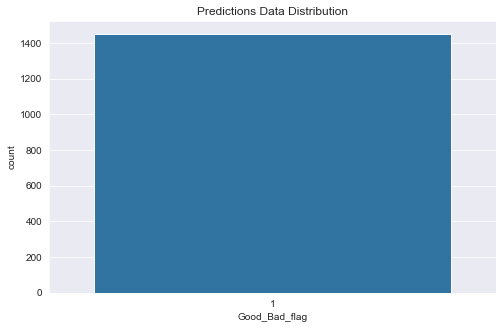

In [1406]:
# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Good_Bad_flag)
plt.title('Predictions Data Distribution');

In [1407]:
predictions

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [1408]:
# Create file
sub_file.to_csv('submissions/1st_submission.csv', index = False)

In [1409]:
sub_file.head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [1410]:
# /////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1411]:
model = list()
resample = list()
precision = list()
recall = list()
F1score = list()
AUCROC = list()

In [1412]:
def test_eval(clf_model, X_test, y_test, algo=None, sampling=None):
    # Test set prediction
    y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('AUC-ROC')
    print('='*60)
    print(roc_auc_score(y_test, y_prob[:,1]))
          
    model.append(algo)
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
    AUCROC.append(roc_auc_score(y_test, y_prob[:,1]))
    resample.append(sampling)

In [1413]:
# DECISION TREE MODEL 2
estimators = [2,10,30,50,100]
# Maximum number of depth in each tree:
max_depth = [i for i in range(5,16,2)]
# Minimum number of samples to consider to split a node:
min_samples_split = [2, 5, 10, 15, 20, 50, 100]
# Minimum number of samples to consider at each leaf node:
min_samples_leaf = [1, 2, 5]

In [1414]:
tree_model = DecisionTreeClassifier()

cv = StratifiedKFold(n_splits=5, random_state=100, shuffle=True)

tree_param_grid = { 
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
}

clf_DT = RandomizedSearchCV(tree_model, tree_param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=2)
clf_DT.fit(X_train, y_train)
clf_DT.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


DecisionTreeClassifier(max_depth=5, min_samples_split=15)

In [1415]:
test_eval(clf_DT, X_test, y_test, 'Decision Tree', 'actual')

Confusion Matrix
[[ 12  83]
 [ 12 329]] 

Classification Report
              precision    recall  f1-score   support

           0       0.50      0.13      0.20        95
           1       0.80      0.96      0.87       341

    accuracy                           0.78       436
   macro avg       0.65      0.55      0.54       436
weighted avg       0.73      0.78      0.73       436
 

AUC-ROC
0.6656891495601173


D:\CRASHOVERRIDE\SOFTWARES\INSTALLED SOFT\CONDA\lib\site-packages\seaborn\utils.py:533: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  np.asarray(values).astype(np.float)


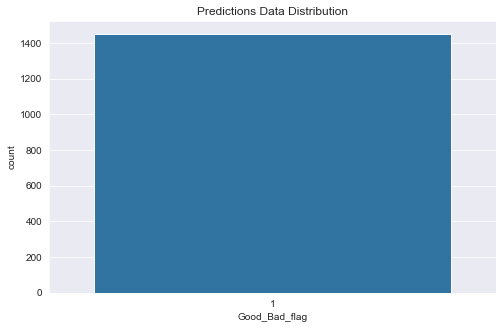

In [1416]:
# Make prediction on the test set
test_df = test[train_feats]
my_predictions = clf_DT.predict(test_df)

my_sub_file = samplesubmission.copy()
my_sub_file['Good_Bad_flag'] = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(my_sub_file.Good_Bad_flag)
plt.title('Predictions Data Distribution');

In [1417]:
# Create file
my_sub_file.to_csv('submissions/2nd_submission.csv', index = False)

In [1418]:
my_sub_file.head()

,customerid,Good_Bad_flag
0,8a28afc7474813a40147639ec637156b,1
1,8a3735d5518aba7301518ac34413010d,1
2,8a76e7d443e6e97c0143ed099d102b1d,1
3,8a818823525dceef01525deda2480384,1
4,8a818926522ea5ef01523aff15c37482,1


In [1419]:
my_sub_file['Good_Bad_flag'].unique()

array([1], dtype=int64)

In [1420]:
# //////////////////////////////////////////////////////////////////////////////////////////////////////////